In [2]:
   #Code for creating the masked array and perform the sky-subtraction.

"""

Connect to katcal_py3 (public) to run script on Jupyter-notebook/Slurm.

"""

#Imports
import numpy as np
import matplotlib.pylab as plt
import warnings
import time
import pickle
import sys
import katcali
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd


def good_ant(fname):

    """
    Fuction to retrieve list of good antennas.
    """

    data=kio.load_data(fname)
    bad_ants=kio.check_ants(fname)

    ants_good = []
    for i in np.array(kio.ant_list(data)):
        if i not in bad_ants:
            ants_good.append(i)
    else:
        print (str(i) + ' is bad')

    return ants_good
"""
Define a function that will access the data block and return visibility data, flags, noise diodes vector. 
"""
def visData(fname, ant, pol):
    """
    Parameters:
    ----------
    Fname: Path to observation block.

    Returns:
    -------
    vis, flags (SARAO prior flags), noise_diodes vector (nd)

    Note : Current function looks at one pol and one dish.
    """

    data = kio.load_data(fname)
    target, c0, band_ants, flux_model = kio.check_ants(fname)
    ants_good = good_ant(fname)
    data.select(ants=ant, pol=pol)
    recv = ant + pol
    print(recv)
    corr_id = kio.cal_corr_id(data, recv)

    assert(recv == data.corr_products[corr_id][0])
    assert(recv == data.corr_products[corr_id][1])

    print("Correlation ID:", corr_id, "Receiver:", recv)

    # Load visibilities and flags
    vis, flags = kio.call_vis(fname, recv)
    print("Shape of vis:", vis.copy().shape)
    vis_backup = vis.copy()

    ra, dec, az, el = kio.load_coordinates(data)
    ang_deg = kio.load_ang_deg(ra, dec, c0)
    ch_ref = 800
    timestamps, freqs = kio.load_tf(data)
    dp_tt, dp_ss, dp_f, dp_w, dp_t, dp_s, dp_slew, dp_stop = kl.cal_dp_label(data, flags, ant, pol, ch_ref, ang_deg)


    nd_on_time, nd_cycle, nd_set = kd.cal_nd_basic_para(fname)
    nd_on_edge, nd_off_edge = kd.cal_nd_edges(timestamps, nd_set, nd_cycle, nd_on_time)
    nd_ratio, nd_0, nd_1x = kd.cal_nd_ratio(timestamps, nd_on_time, nd_on_edge, data.dump_period)


    nd_t0, nd_t1x, nd_s0, nd_s1x, nd_t0_ca, nd_t0_cb, nd_t1x_ca, nd_t1x_cb = kl.cal_label_intersec(dp_tt, dp_ss, nd_0, nd_1x)

    return vis, nd_s0


def MaskedArrayVisibilityFlags(vis, flags_mask, nd_s0):
    """
    Reason of the masked array: Apply masks to noise diodes and bright RFI flags, so that they are not time differenced in the TOD array. Ensures that we are performing correct neighbouring time channel subtractions
    
    Parameters:
    ----------
    visibility, flags and nd_s0 from the visData Fuction.

    Returns:
    --------
    Visibility-Flags Masked Array
    """
    #vis, flags, nd_s0 = visData(fname)
    data0 = vis.copy


    nd_flags = np.ones_like(vis, dtype=bool)          # Empty mask, where all values are set to true. True is flagged data
    nd_flags[nd_s0, :] = False                        # Set the data with noise diodes removed to False so that this data is not flagged as bad data.  This is the scan only data.
    #other_flags = np.logical_or(flags, flags_mask)   # All other flags from the visData function. Boolean value is True.
    other_flags = flags_mask 

    allflags =  np.logical_or(nd_flags, other_flags)  # Apply logical operator or to combine the noise diode flags, and visilibity data at a specific stage flags. 

    data_masked = np.ma.masked_array(vis, mask=allflags, fill_value = np.nan)

    return data_masked

def SkySubtraction(data_masked):

    """
    Function Returns differencing of the  visibility masked array.
    """

    vis_ss =data_masked[1:,:] - data_masked[0:-1,:]
    visSS=vis_ss.filled()

    return visSS



def abba(array: np.ndarray):
    """Calculate ABBA dithering (interpolation) from a 1D array (time series).
    Performs 4 channel differencing of time.
    
    Parameters
    -------
    array: np.ndarray
        Numpy array of visibility as a function of time dump.
        Can be masked array (np.nan will be propagated)

    Returns
    -------
    out: ndarray after ABBA (shape N-3)
    """
    array = array.filled()
    vis_abba = (array[1:-2]+array[2:-1])/2 - (array[0:-3]+array[3:])/2
    return vis_abba




def plot_bandpass(x : np.ndarray, y : np.ndarray, label=None, Title =None, ylim : tuple = None, figsize=(8, 3), ax=None):
    """Plot bandpass (visibility vs frequency channel)"""
    if ax is None:  # Create a new figure and axes if not being passed in as a parameter
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(x, y, label=label)
    if ylim is not None:
        ax.set_ylim(*ylim)
    return ax

def plot(x : np.ndarray, label=None, Title =None, ylim : tuple = None, figsize=(20, 6), ax=None):
    """Plot bandpass (visibility vs frequency channel)"""
    if ax is None:  # Create a new figure and axes if not being passed in as a parameter
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(x, label=label)
    ax.legend()
    if ylim is not None:
        ax.set_ylim(*ylim)
        
    return ax



def plot_waterfall(x : np.ndarray,label=None,  Title =None, ylim : tuple = None, figsize=None, ax=None, vmax=None):
    """Plot bandpass (visibility vs frequency channel)"""
    if ax is None:  # Create a new figure and axes if not being passed in as a parameter
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow((x), label=label, vmax=vmax, interpolation=None, cmap='viridis', aspect='auto')
    ax.set_title(Title)
    
    if ylim is not None:
        ax.set_ylim(*ylim)
    return ax


def plot_hist(x : np.ndarray, label=None, Title =None, ylim : tuple = None, figsize=None, ax=None, bins=None, alpha=None, density=True, color='r',edgecolor='black'):
    """Plot bandpass (visibility vs frequency channel)"""
    if ax is None:  # Create a new figure and axes if not being passed in as a parameter
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.hist(x, label=label,bins=bins, alpha=alpha, density=density, color=color, edgecolor=edgecolor)
    ax.legend()
    if ylim is not None:
        ax.set_ylim(*ylim)
        
    return ax



def ants_checked_L1(fname, path):
    obsfolder = Path(path)
    
    ants =[]
    obsblock_ant_pol = []
    for f in sorted(obsfolder.glob(fname+'_m*h*')):
        filename =  f.name.split('_')[0]
        antpol = f.name.split('1630519596_')[1]
        ant= antpol[0:4].split('h')
        ants.append(ant)
        pol = antpol[4:5]
        
       
    return(ants)


In [3]:
#path lib to collect all the gooo antennas
#make into a function

from pathlib import Path
fname = '1630519596' 
path = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level1/mask/checked/'
pol = 'h'

In [4]:
obsfolder = Path('/idia/projects/hi_im/raw_vis/MeerKLASS2021/level1/mask/checked/')
obsblock_ant_pol = []
for f in sorted(obsfolder.glob(fname+'_m*h*')):
    
    obsblock_ant_pol.append(f.name.split('_'))
   

In [5]:
print(f'Observation Block: {obsblock_ant_pol[0][0]}')
print(f'Antenna: {[entry[1] for entry in obsblock_ant_pol]}')
print(f'Polarisation: {(obsblock_ant_pol[0][1][4:])}')

Observation Block: 1630519596
Antenna: ['m000h', 'm001h', 'm002h', 'm003h', 'm004h', 'm005h', 'm006h', 'm007h', 'm008h', 'm009h', 'm010h', 'm011h', 'm012h', 'm013h', 'm014h', 'm015h', 'm016h', 'm017h', 'm018h', 'm019h', 'm020h', 'm021h', 'm023h', 'm024h', 'm025h', 'm027h', 'm029h', 'm030h', 'm031h', 'm032h', 'm033h', 'm035h', 'm036h', 'm037h', 'm038h', 'm039h', 'm040h', 'm041h', 'm042h', 'm043h', 'm044h', 'm045h', 'm046h', 'm047h', 'm048h', 'm049h', 'm050h', 'm051h', 'm052h', 'm053h', 'm054h', 'm055h', 'm056h', 'm057h', 'm058h', 'm059h', 'm061h', 'm062h', 'm063h']
Polarisation: h


In [6]:

ants = ants_checked_L1(fname, path)

for ant in ants:
    print(ant[0])
 

m000
m001
m002
m003
m004
m005
m006
m007
m008
m009
m010
m011
m012
m013
m014
m015
m016
m017
m018
m019
m020
m021
m023
m024
m025
m027
m029
m030
m031
m032
m033
m035
m036
m037
m038
m039
m040
m041
m042
m043
m044
m045
m046
m047
m048
m049
m050
m051
m052
m053
m054
m055
m056
m057
m058
m059
m061
m062
m063


In [7]:
#This will loop over the ants in the list of antennas with masks and access the visData function,stores the visibilities as an dictorinary 

vis_products = {}
nds0_products ={}

for ant in ants:
    for i in ant:
        vis,nd_s0 = visData(fname, i , pol)
        vis_products[i] = (vis)
        nds0_products[i] =(nd_s0)
    
    

calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m000h
Correlation ID: 0 Receiver: m000h
# loaded data was saved in python2
['m000h' 'm000h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m001h
Correlation ID: 0 Receiver: m001h
# loaded data was saved in python2
['m001h' 'm001h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m002h
Correlation ID: 0 Receiver: m002h
# loaded data was saved in python2
['m002h' 'm002h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m003h
Correlation ID: 0 Receiver: m003h
# loaded data was saved in python2
['m003h' 'm003h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m004h
Correlation ID: 0 Receiver: m004h
# loaded data was saved in python2
['m004h' 'm004h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m005h
Correlation ID: 0 Receiver: m005h
# loaded data was saved in python2
['m005h' 'm005h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m006h
Correlation ID: 0 Receiver: m006h
# loaded data was saved in python2
['m006h' 'm006h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m007h
Correlation ID: 0 Receiver: m007h
# loaded data was saved in python2
['m007h' 'm007h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m008h
Correlation ID: 0 Receiver: m008h
# loaded data was saved in python2
['m008h' 'm008h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m009h
Correlation ID: 0 Receiver: m009h
# loaded data was saved in python2
['m009h' 'm009h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m010h
Correlation ID: 0 Receiver: m010h
# loaded data was saved in python2
['m010h' 'm010h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m011h
Correlation ID: 0 Receiver: m011h
# loaded data was saved in python2
['m011h' 'm011h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m012h
Correlation ID: 0 Receiver: m012h
# loaded data was saved in python2
['m012h' 'm012h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m013h
Correlation ID: 0 Receiver: m013h
# loaded data was saved in python2
['m013h' 'm013h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m014h
Correlation ID: 0 Receiver: m014h
# loaded data was saved in python2
['m014h' 'm014h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m015h
Correlation ID: 0 Receiver: m015h
# loaded data was saved in python2
['m015h' 'm015h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m016h
Correlation ID: 0 Receiver: m016h
# loaded data was saved in python2
['m016h' 'm016h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m017h
Correlation ID: 0 Receiver: m017h
# loaded data was saved in python2
['m017h' 'm017h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m018h
Correlation ID: 0 Receiver: m018h
# loaded data was saved in python2
['m018h' 'm018h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m019h
Correlation ID: 0 Receiver: m019h
# loaded data was saved in python2
['m019h' 'm019h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m020h
Correlation ID: 0 Receiver: m020h
# loaded data was saved in python2
['m020h' 'm020h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m021h
Correlation ID: 0 Receiver: m021h
# loaded data was saved in python2
['m021h' 'm021h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m023h
Correlation ID: 0 Receiver: m023h
# loaded data was saved in python2
['m023h' 'm023h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m024h
Correlation ID: 0 Receiver: m024h
# loaded data was saved in python2
['m024h' 'm024h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m025h
Correlation ID: 0 Receiver: m025h
# loaded data was saved in python2
['m025h' 'm025h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m027h
Correlation ID: 0 Receiver: m027h
# loaded data was saved in python2
['m027h' 'm027h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m029h
Correlation ID: 0 Receiver: m029h
# loaded data was saved in python2
['m029h' 'm029h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m030h
Correlation ID: 0 Receiver: m030h
# loaded data was saved in python2
['m030h' 'm030h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m031h
Correlation ID: 0 Receiver: m031h
# loaded data was saved in python2
['m031h' 'm031h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m032h
Correlation ID: 0 Receiver: m032h
# loaded data was saved in python2
['m032h' 'm032h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m033h
Correlation ID: 0 Receiver: m033h
# loaded data was saved in python2
['m033h' 'm033h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m035h
Correlation ID: 0 Receiver: m035h
# loaded data was saved in python2
['m035h' 'm035h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m036h
Correlation ID: 0 Receiver: m036h
# loaded data was saved in python2
['m036h' 'm036h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m037h
Correlation ID: 0 Receiver: m037h
# loaded data was saved in python2
['m037h' 'm037h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m038h
Correlation ID: 0 Receiver: m038h
# loaded data was saved in python2
['m038h' 'm038h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m039h
Correlation ID: 0 Receiver: m039h
# loaded data was saved in python2
['m039h' 'm039h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m040h
Correlation ID: 0 Receiver: m040h
# loaded data was saved in python2
['m040h' 'm040h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m041h
Correlation ID: 0 Receiver: m041h
# loaded data was saved in python2
['m041h' 'm041h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m042h
Correlation ID: 0 Receiver: m042h
# loaded data was saved in python2
['m042h' 'm042h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m043h
Correlation ID: 0 Receiver: m043h
# loaded data was saved in python2
['m043h' 'm043h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m044h
Correlation ID: 0 Receiver: m044h
# loaded data was saved in python2
['m044h' 'm044h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m045h
Correlation ID: 0 Receiver: m045h
# loaded data was saved in python2
['m045h' 'm045h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m046h
Correlation ID: 0 Receiver: m046h
# loaded data was saved in python2
['m046h' 'm046h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m047h
Correlation ID: 0 Receiver: m047h
# loaded data was saved in python2
['m047h' 'm047h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m048h
Correlation ID: 0 Receiver: m048h
# loaded data was saved in python2
['m048h' 'm048h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m049h
Correlation ID: 0 Receiver: m049h
# loaded data was saved in python2
['m049h' 'm049h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m050h
Correlation ID: 0 Receiver: m050h
# loaded data was saved in python2
['m050h' 'm050h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m051h
Correlation ID: 0 Receiver: m051h
# loaded data was saved in python2
['m051h' 'm051h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m052h
Correlation ID: 0 Receiver: m052h
# loaded data was saved in python2
['m052h' 'm052h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m053h
Correlation ID: 0 Receiver: m053h
# loaded data was saved in python2
['m053h' 'm053h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m054h
Correlation ID: 0 Receiver: m054h
# loaded data was saved in python2
['m054h' 'm054h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m055h
Correlation ID: 0 Receiver: m055h
# loaded data was saved in python2
['m055h' 'm055h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m056h
Correlation ID: 0 Receiver: m056h
# loaded data was saved in python2
['m056h' 'm056h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m057h
Correlation ID: 0 Receiver: m057h
# loaded data was saved in python2
['m057h' 'm057h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m058h
Correlation ID: 0 Receiver: m058h
# loaded data was saved in python2
['m058h' 'm058h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m059h
Correlation ID: 0 Receiver: m059h
# loaded data was saved in python2
['m059h' 'm059h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m061h
Correlation ID: 0 Receiver: m061h
# loaded data was saved in python2
['m061h' 'm061h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m062h
Correlation ID: 0 Receiver: m062h
# loaded data was saved in python2
['m062h' 'm062h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
m063 is bad
m063h
Correlation ID: 0 Receiver: m063h
# loaded data was saved in python2
['m063h' 'm063h']
Shape of vis: (3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


In [8]:
vis_products.keys()

dict_keys(['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm023', 'm024', 'm025', 'm027', 'm029', 'm030', 'm031', 'm032', 'm033', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm052', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063'])

In [9]:
nds0_products.keys()

dict_keys(['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm023', 'm024', 'm025', 'm027', 'm029', 'm030', 'm031', 'm032', 'm033', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm052', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063'])

In [10]:
# adding the masked flags from the checked folder


flags_mask_L1 = {}
for dish, (vis) in vis_products.items():
    
    try:
        d3 = pickle.load(open('/idia/projects/hi_im/raw_vis/MeerKLASS2021/level1/mask/checked/'+fname+'_'+dish+'_mask2', 'rb'))
        print (f'mask2 loaded for dish {dish}')
    except(Exception):
        d3 = pickle.load(open('/idia/projects/hi_im/raw_vis/MeerKLASS2021/level1/mask/checked/'+fname+'_'+dish+'_mask', 'rb'))
        print (f'mask loaded for dish {dish}')
    mask_flags=d3['mask']
    flags_mask_L1[dish]  = mask_flags
    
        
   
    #print(dish)

mask loaded for dish m000
mask loaded for dish m001
mask2 loaded for dish m002
mask loaded for dish m003
mask loaded for dish m004
mask loaded for dish m005
mask2 loaded for dish m006
mask loaded for dish m007
mask2 loaded for dish m008
mask loaded for dish m009
mask loaded for dish m010
mask loaded for dish m011
mask loaded for dish m012
mask2 loaded for dish m013
mask loaded for dish m014
mask2 loaded for dish m015
mask loaded for dish m016
mask2 loaded for dish m017
mask2 loaded for dish m018
mask2 loaded for dish m019
mask2 loaded for dish m020
mask loaded for dish m021
mask2 loaded for dish m023
mask loaded for dish m024
mask loaded for dish m025
mask2 loaded for dish m027
mask2 loaded for dish m029
mask loaded for dish m030
mask2 loaded for dish m031
mask loaded for dish m032
mask loaded for dish m033
mask2 loaded for dish m035
mask loaded for dish m036
mask loaded for dish m037
mask loaded for dish m038
mask2 loaded for dish m039
mask loaded for dish m040
mask loaded for dish m0

In [11]:
flags_mask_L1.keys()


dict_keys(['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm023', 'm024', 'm025', 'm027', 'm029', 'm030', 'm031', 'm032', 'm033', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm052', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063'])

In [12]:
from collections import defaultdict #stackexchange suggestion

d1 = flags_mask_L1
d2 = vis_products
d3 =nds0_products

dd = defaultdict(list)

for d in (d1, d2, d3): # you can list as many input dicts as y
    for key, value in d.items():
        dd[key].append(value)
    
print(dd) # result: defaultdict(<type 'list'>, {1: [2, 6], 3: [4, 7]})


defaultdict(<class 'list'>, {'m000': [array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]]), array([[366.29751587,  62.51673126,  62.47373581, ...,   0.        ,
          0.        ,   0.        ],
       [378.96554565,  73.60748291,  73.96704102, ...,  87.94789124,
         88.41603851,  89.15293884],
       [366.03469849,  62.4033699 ,  62.65620041, ...,  78.47024536,
         79.04814911,  79.82781982],
       ...,
       [645.43511963,  71.5569458 ,  71.52669525, ...,  57.27457047,
         57.42282486,  58.23122787],
       [652.61529541,  72.38539886,  72.42293549, ...,  57.50582886,
         57.67279053,  58.55394745],
       [646.29705811,  71.72380829,  71.87686157, ...,  57.16184235,
 

In [13]:
dd.keys()

dict_keys(['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm023', 'm024', 'm025', 'm027', 'm029', 'm030', 'm031', 'm032', 'm033', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm052', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063'])

In [14]:
masked_data = {}

for dish, (mask_flags, vis , nd_s0) in dd.items():
    masked_vis = MaskedArrayVisibilityFlags(vis, mask_flags, nd_s0)
    masked_data[dish] = masked_vis

In [15]:
masked_data.keys()

dict_keys(['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm023', 'm024', 'm025', 'm027', 'm029', 'm030', 'm031', 'm032', 'm033', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm052', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063'])

In [16]:
data = masked_data['m000']

In [17]:
data.filled()
data[1010:1030, 3001]

masked_array(data=[191.5840606689453, 191.52711486816406,
                   191.02377319335938, 191.1136932373047,
                   191.52383422851562, --, 191.51231384277344,
                   190.77838134765625, 191.3671417236328,
                   191.19871520996094, 191.0546875, 191.41329956054688,
                   191.4696807861328, 191.53646850585938,
                   191.54527282714844, --, 191.7865753173828,
                   191.30450439453125, 190.9711151123047,
                   190.95176696777344],
             mask=[False, False, False, False, False,  True, False, False,
                   False, False, False, False, False, False, False,  True,
                   False, False, False, False],
       fill_value=nan)

In [18]:
data = masked_data['m001']

In [19]:
data.filled()
data[1010:1030, 3001]

masked_array(data=[206.54782104492188, 205.9999237060547,
                   206.0950469970703, 206.3173828125, 206.20895385742188,
                   --, 206.2098388671875, 206.54991149902344,
                   206.77145385742188, 206.68724060058594,
                   206.20452880859375, 206.76812744140625,
                   206.2050018310547, 205.95574951171875,
                   205.67471313476562, --, 206.51605224609375,
                   207.15853881835938, 206.65614318847656,
                   207.76087951660156],
             mask=[False, False, False, False, False,  True, False, False,
                   False, False, False, False, False, False, False,  True,
                   False, False, False, False],
       fill_value=nan)

In [20]:
#After the masking of the data and the flags we apply the sky-subtraction function
visSS_All = {}
for ant_value,(masked_vis) in masked_data.items():
    # Applying the function to create SkySubtraction
    visSS_data = abba(masked_vis)
    visSS_All[ant_value] = visSS_data


In [21]:
visSS_All.keys()

dict_keys(['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm023', 'm024', 'm025', 'm027', 'm029', 'm030', 'm031', 'm032', 'm033', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm052', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063'])

In [22]:
stacked_visSS = np.stack(list(visSS_All.values()), axis=0)

In [23]:
SS_all_ants = stacked_visSS


In [24]:
SS_all_ants[0, :, 3000]

array([nan, nan, nan, ..., nan, nan, nan])

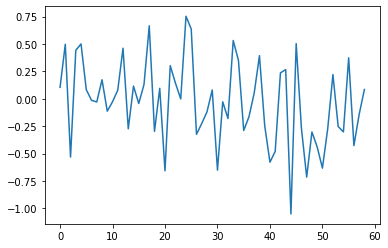

In [26]:
plt.plot(SS_all_ants[:, 1010, 3000])  #this shows that the masked array Sky subs are now done as expected, yay

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:163: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


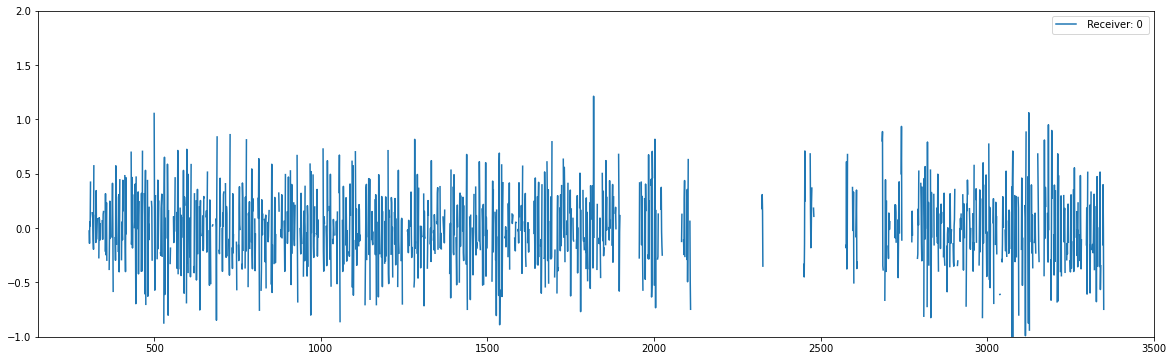

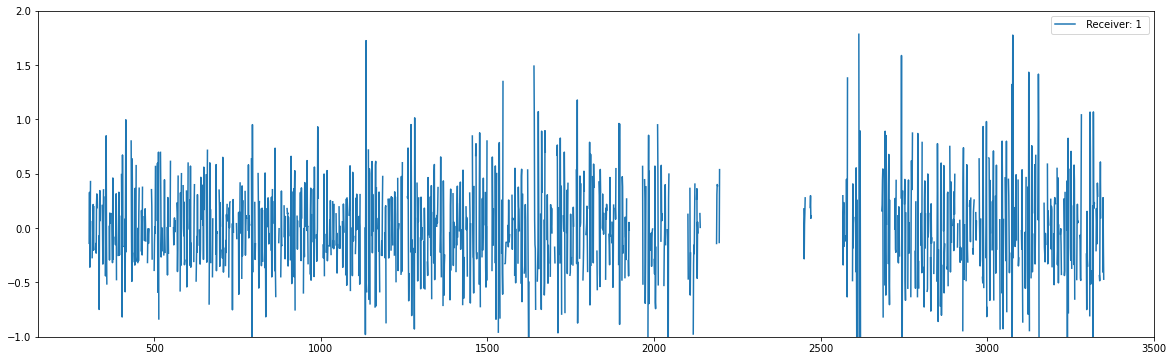

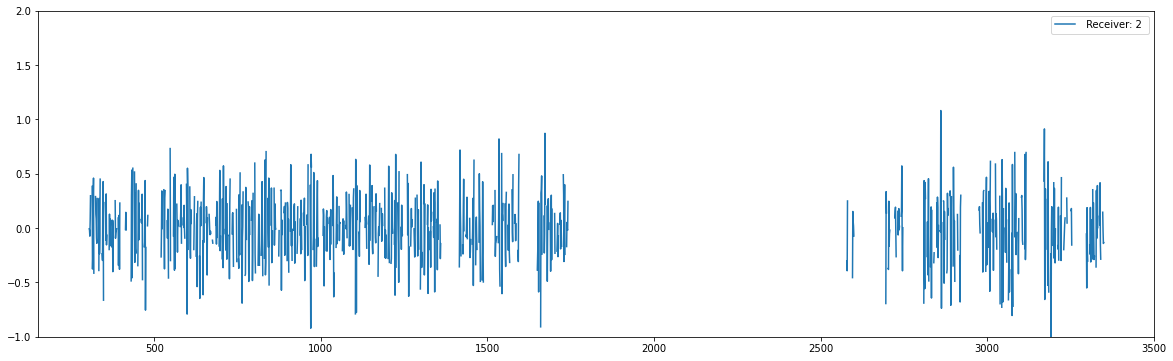

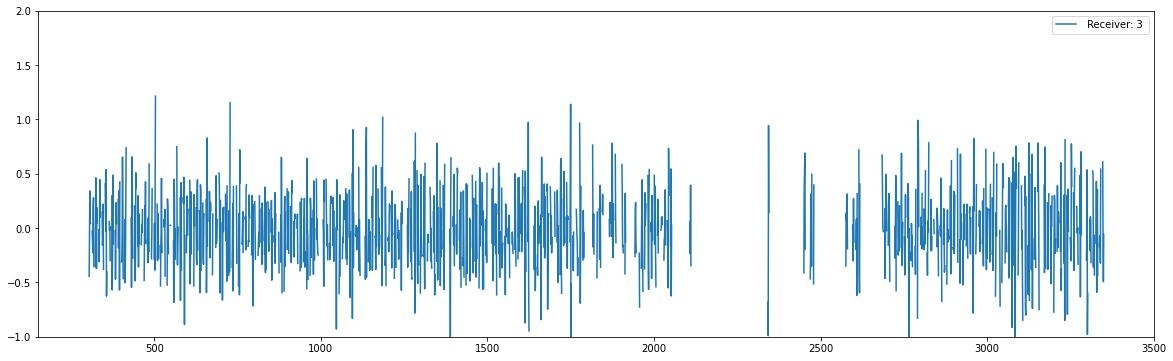

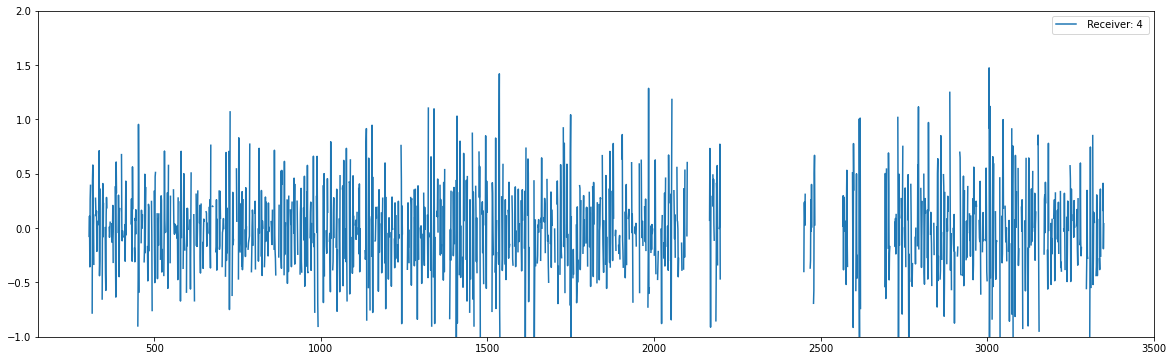

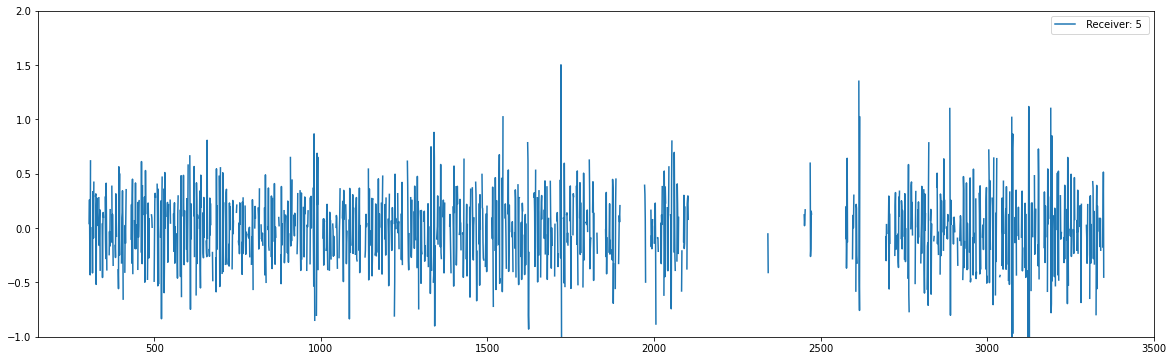

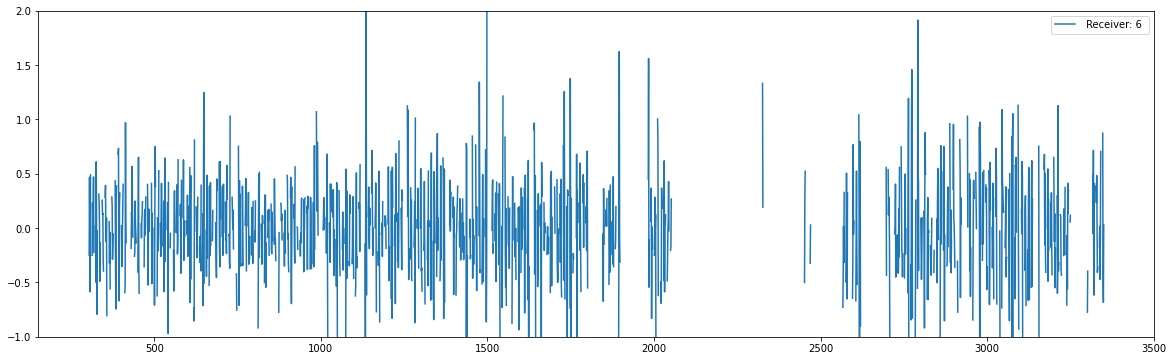

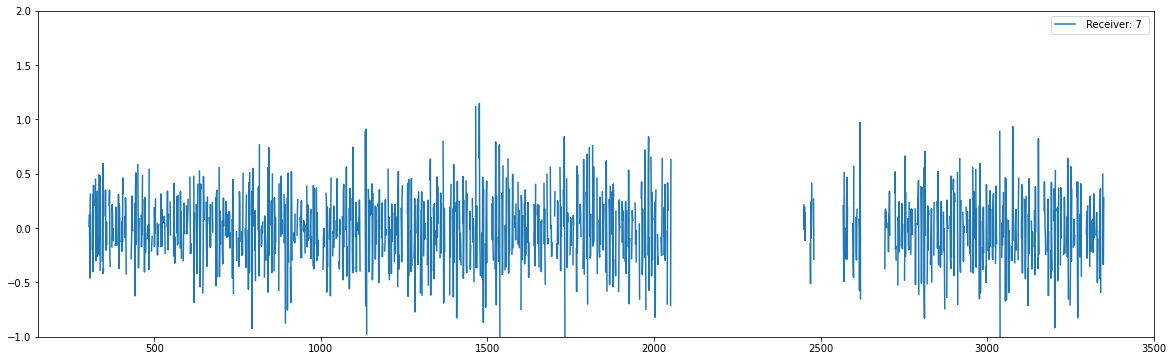

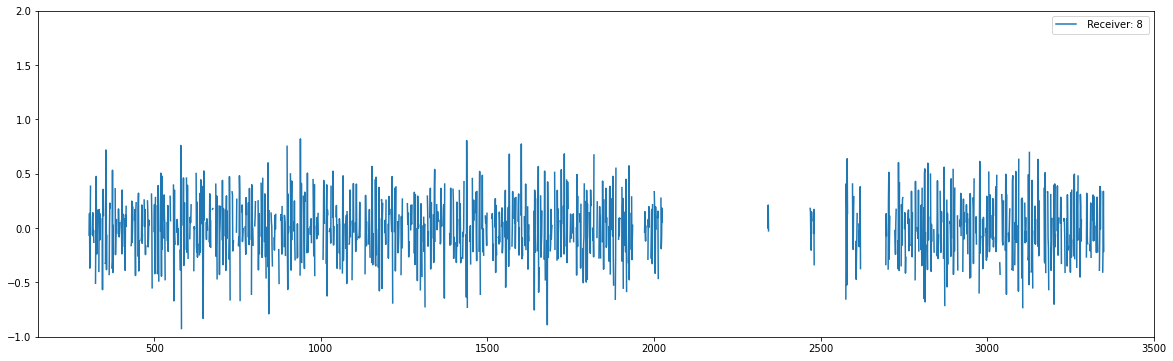

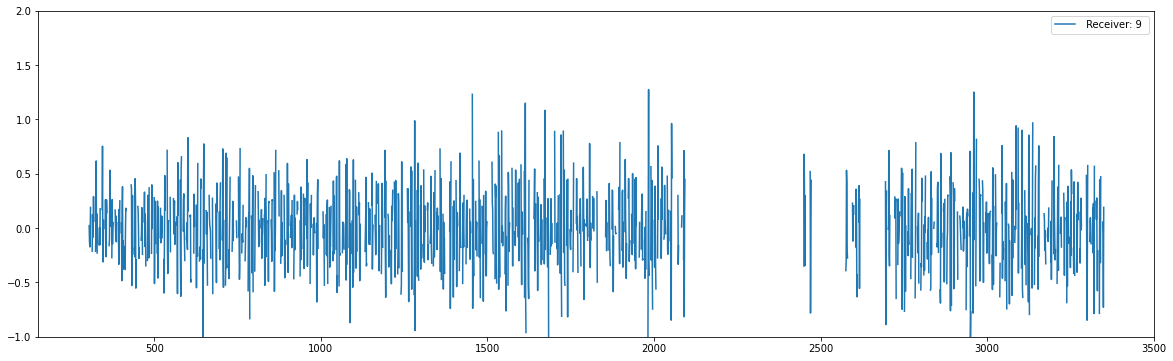

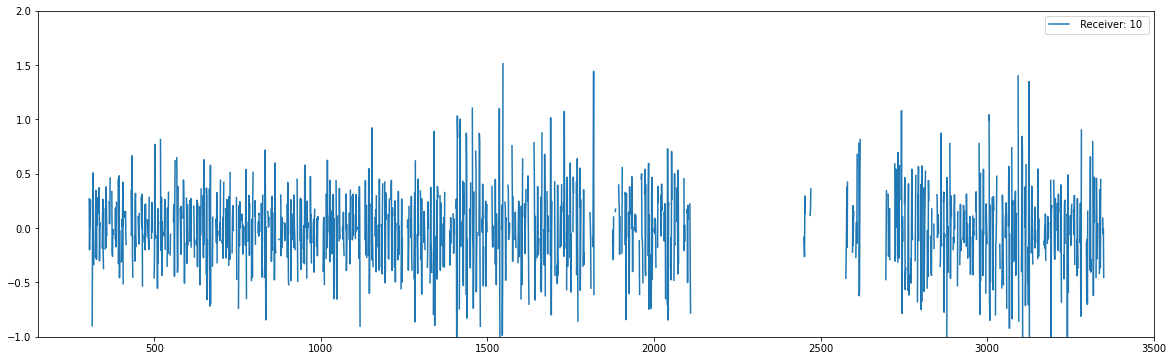

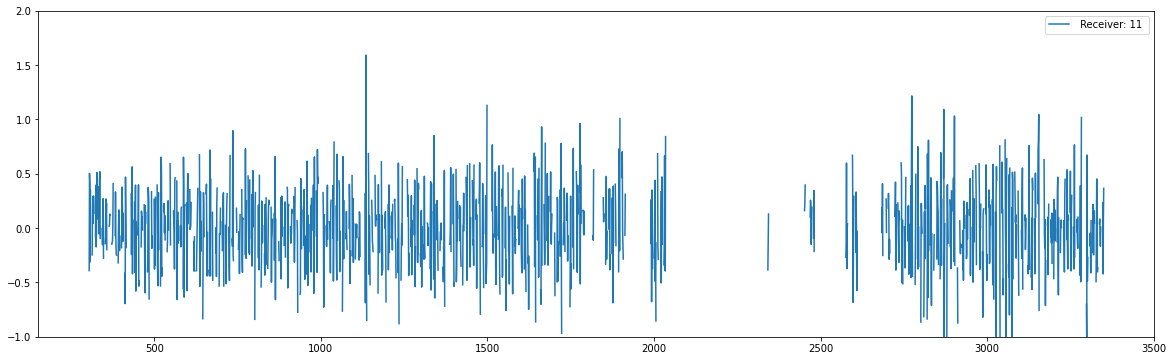

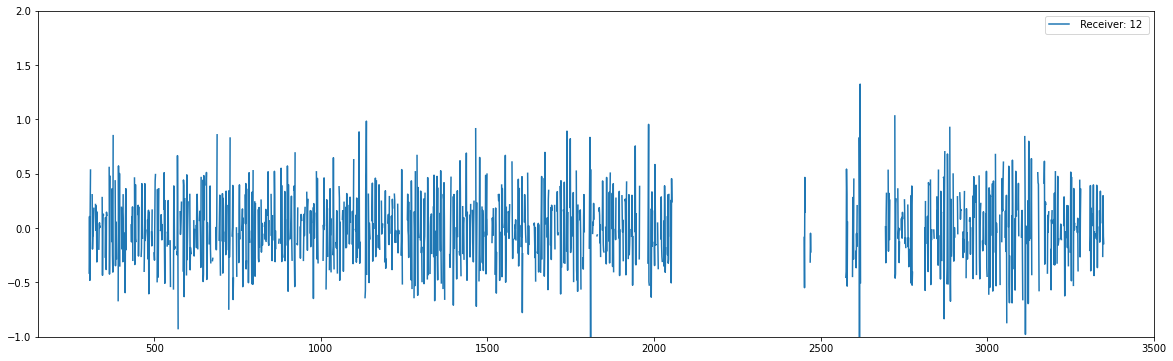

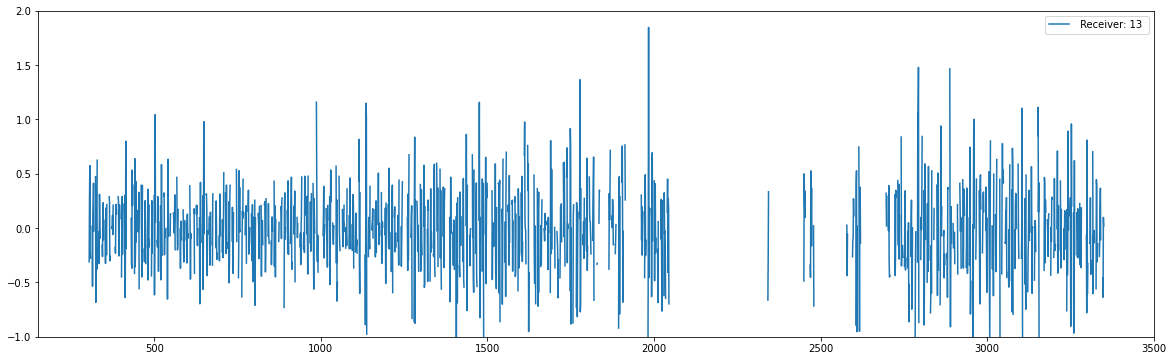

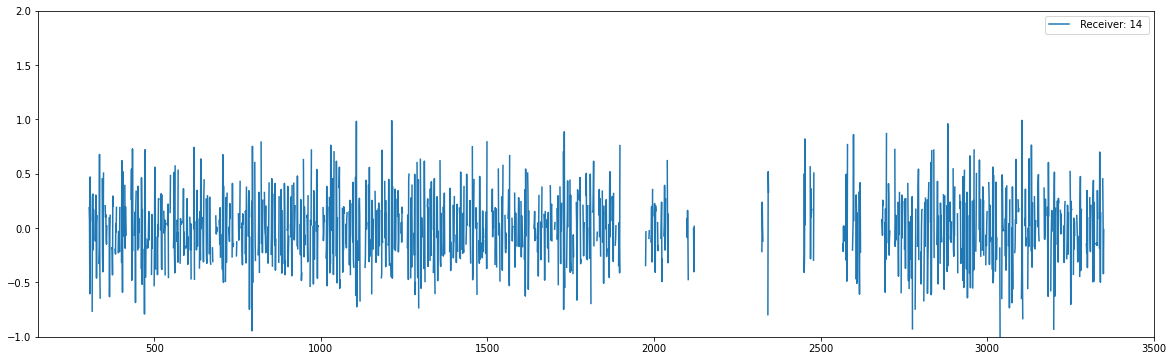

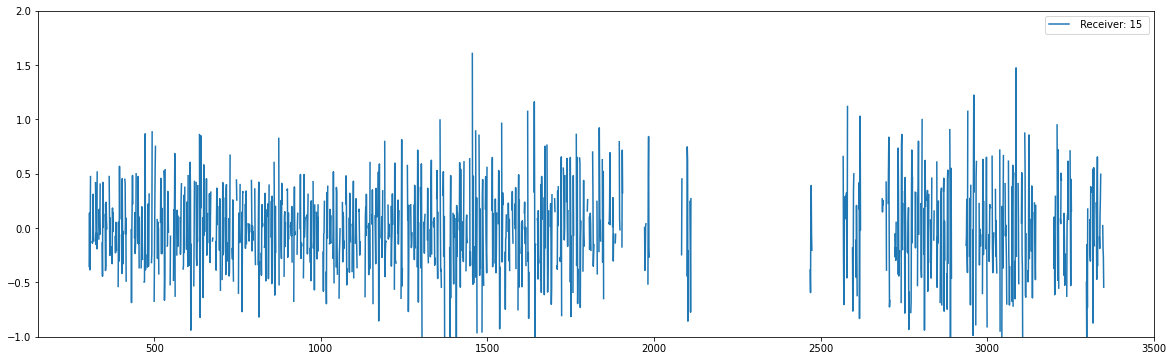

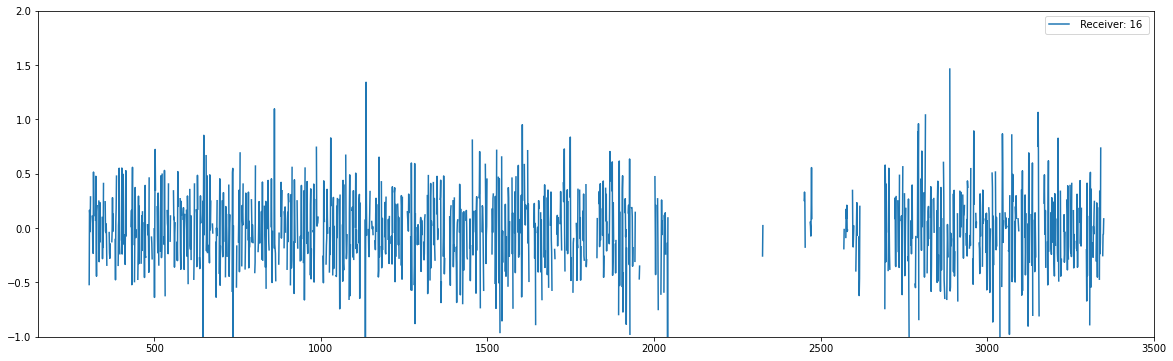

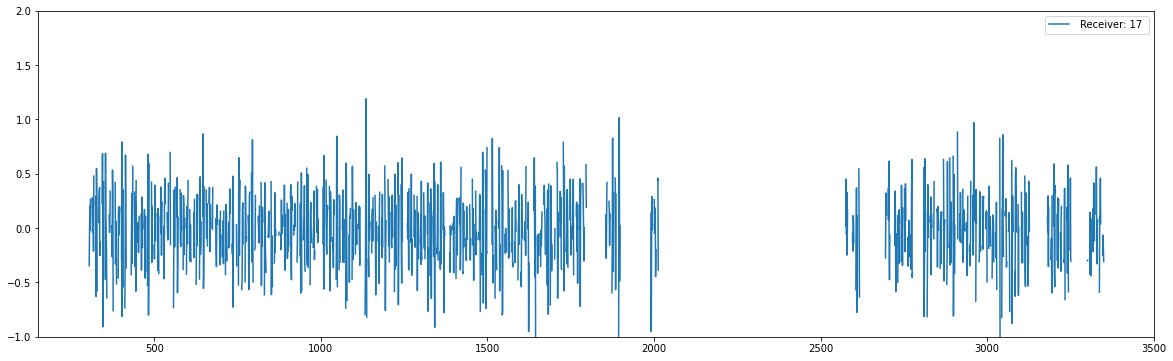

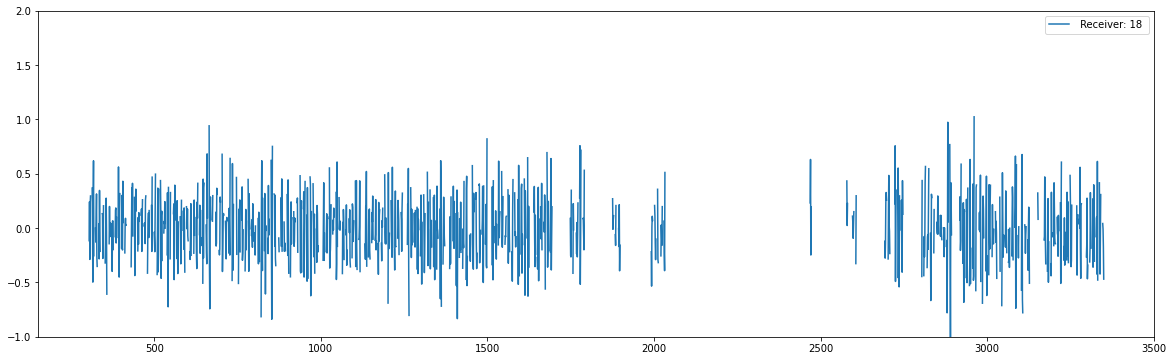

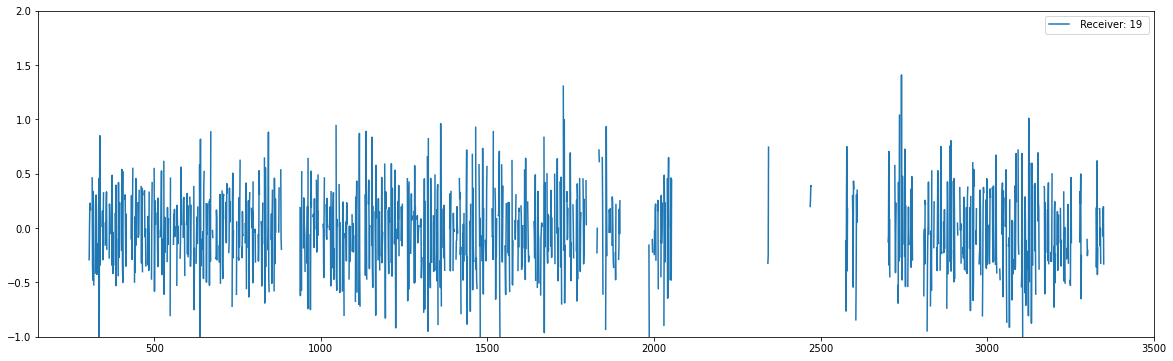

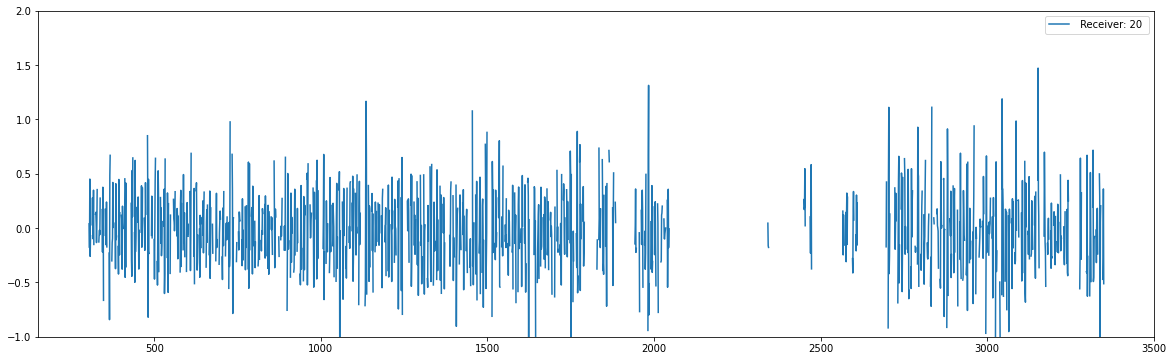

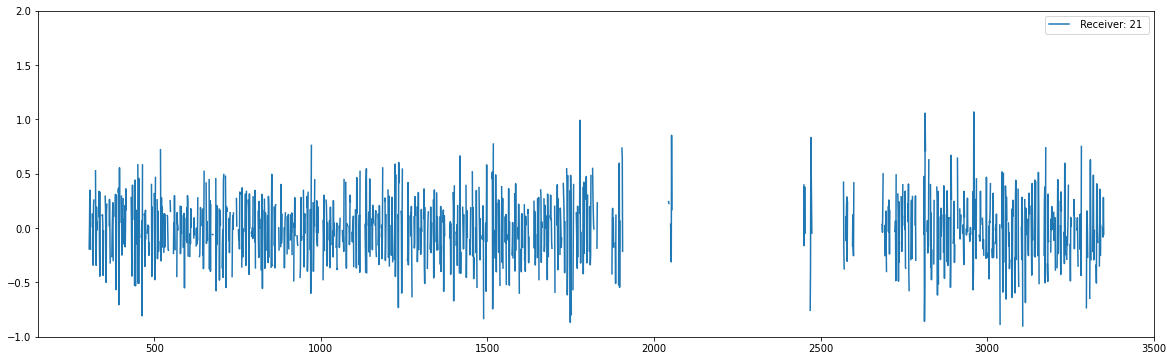

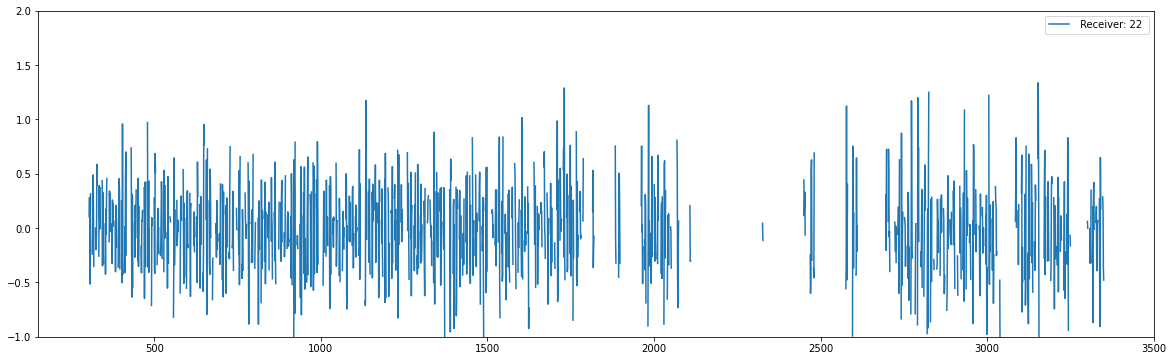

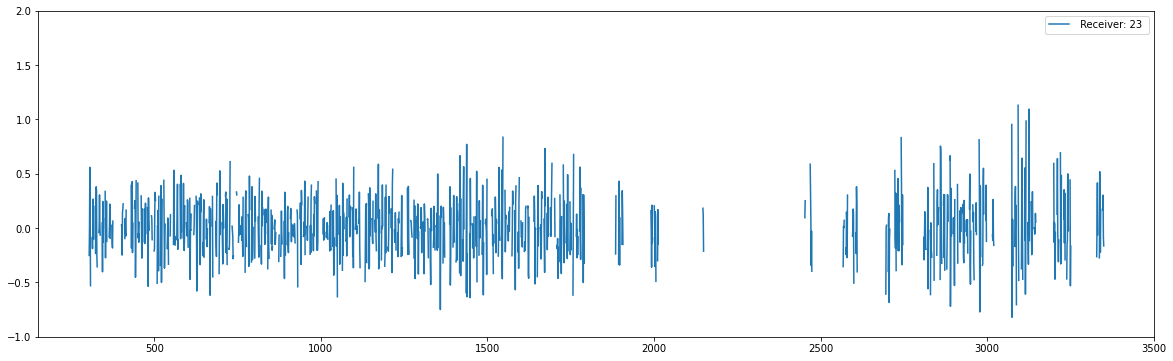

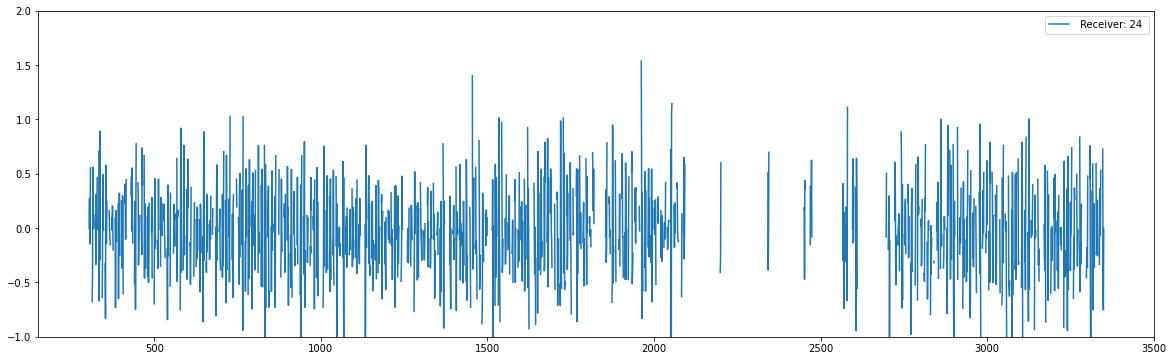

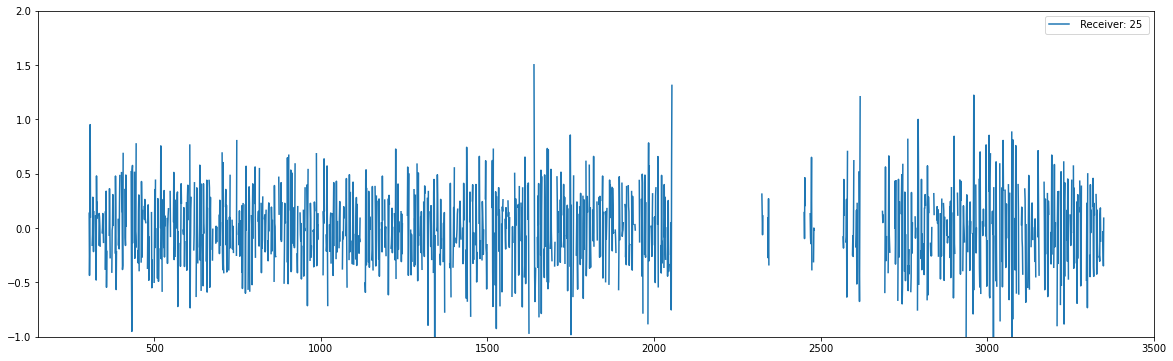

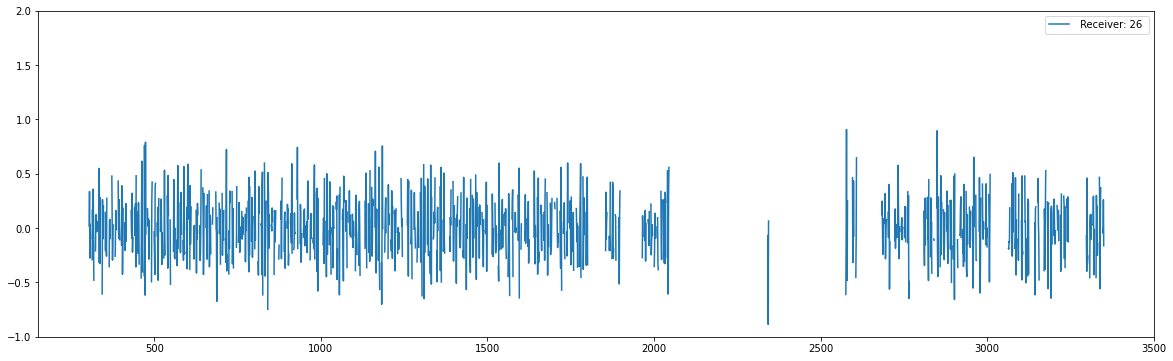

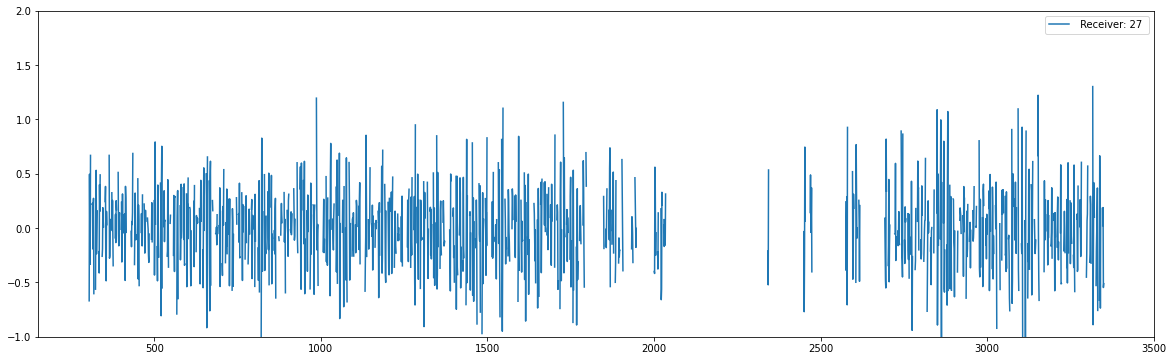

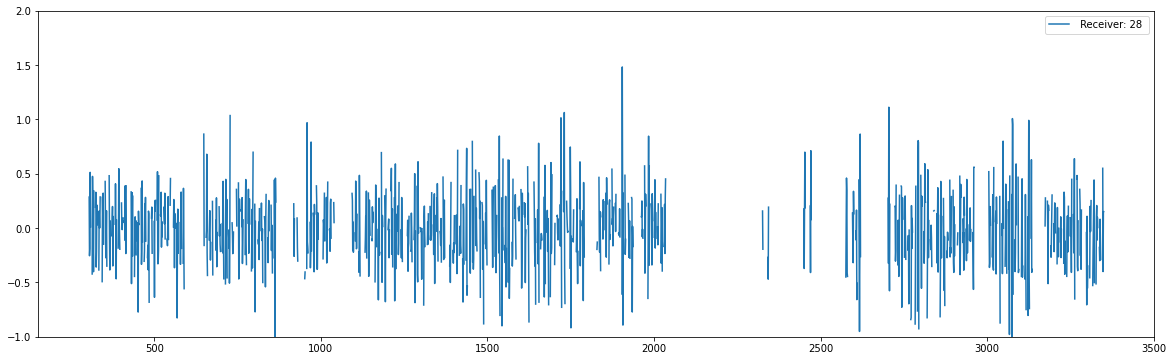

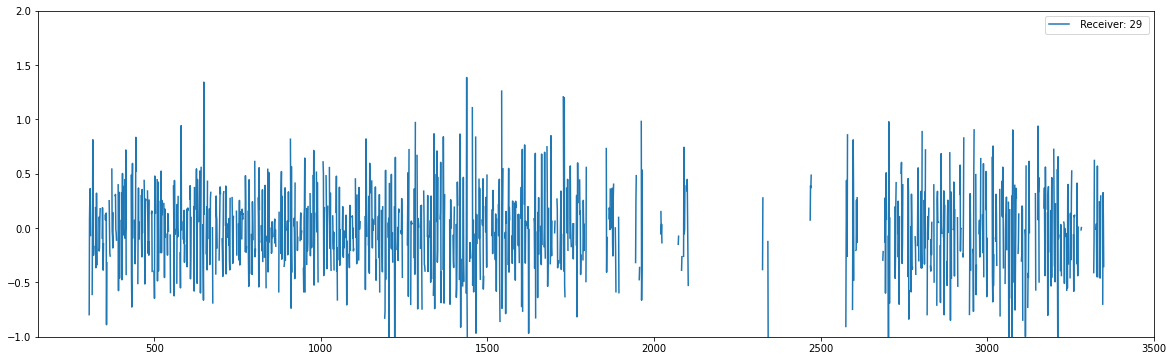

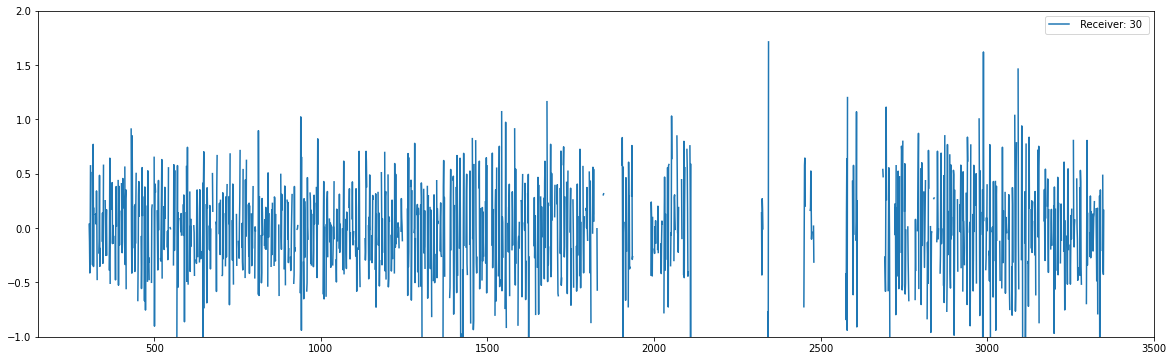

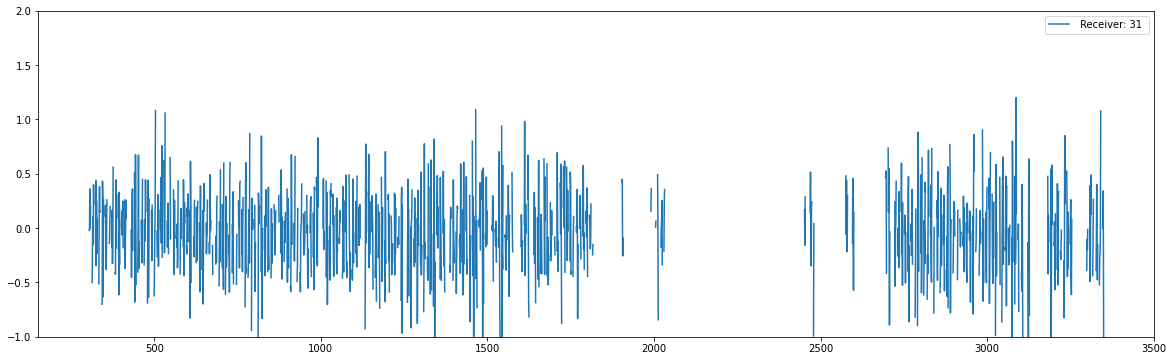

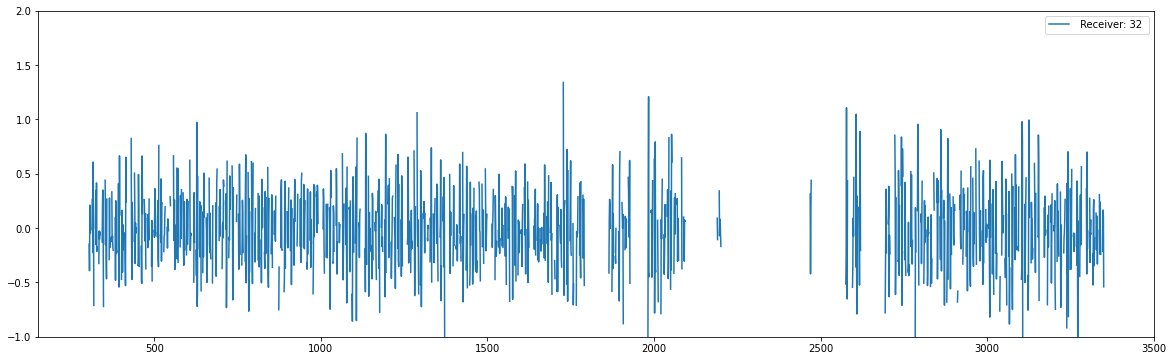

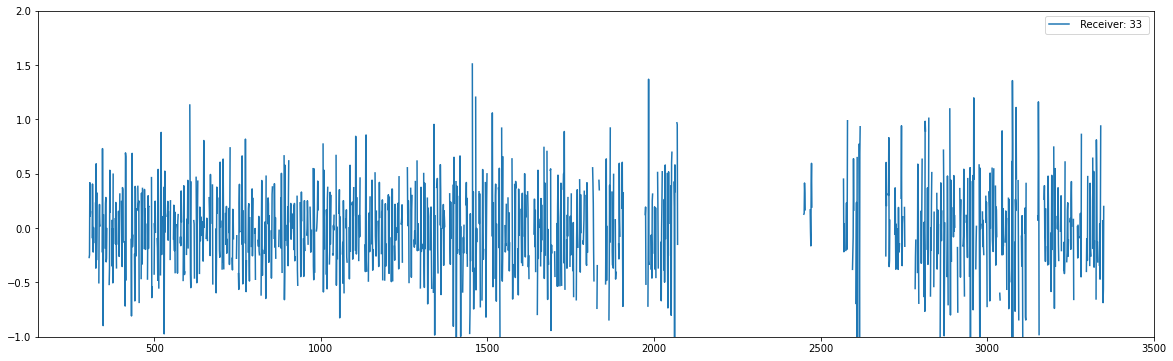

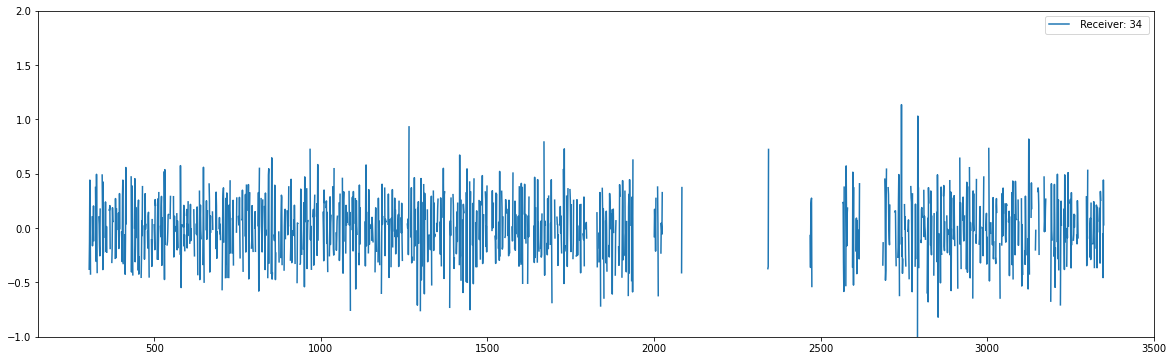

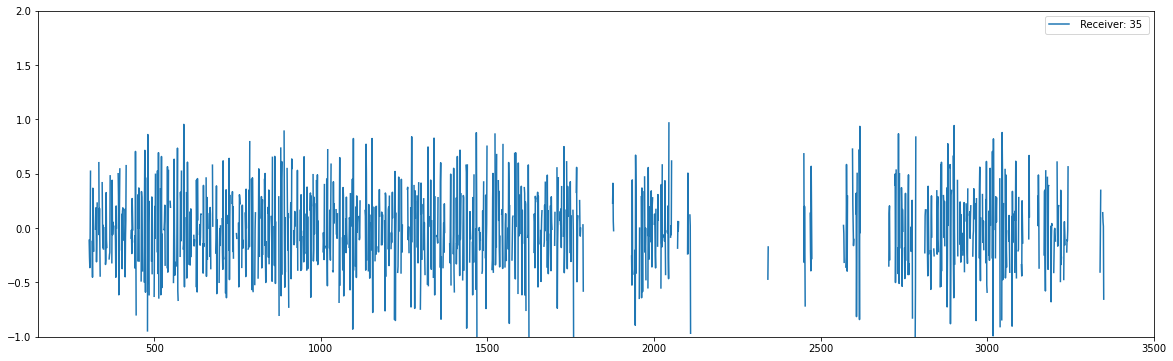

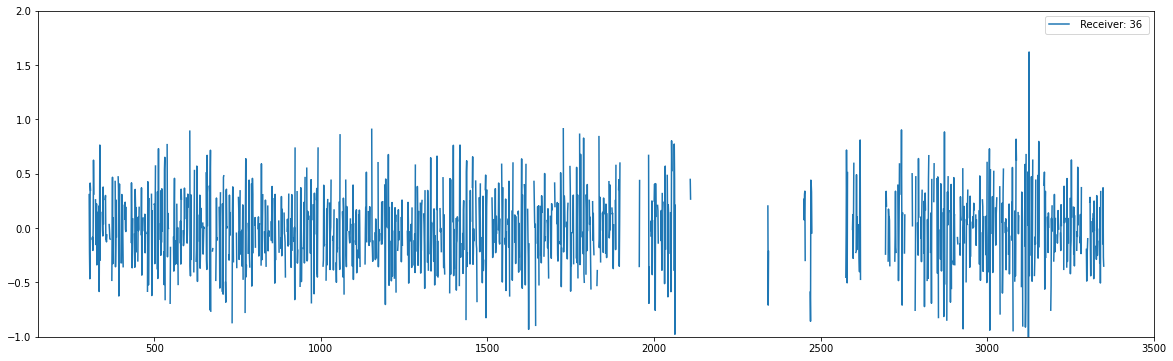

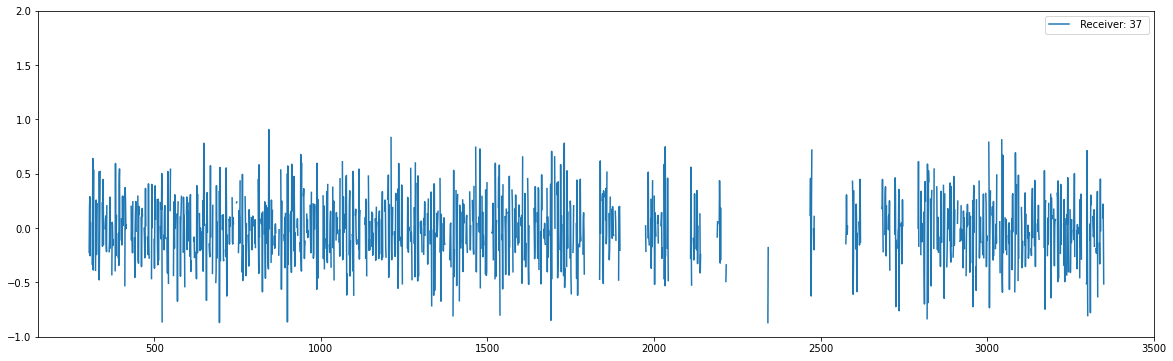

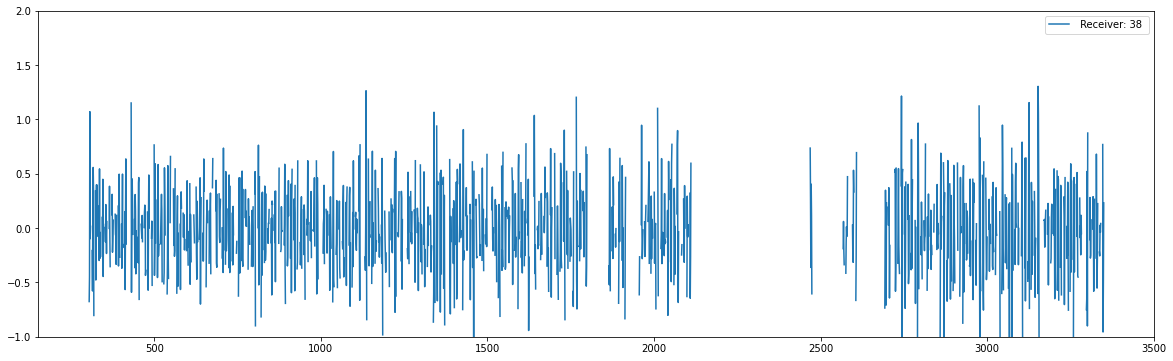

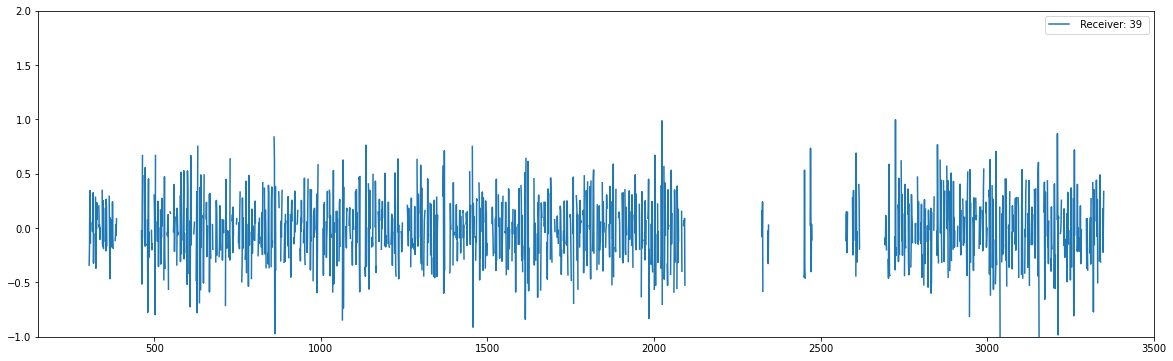

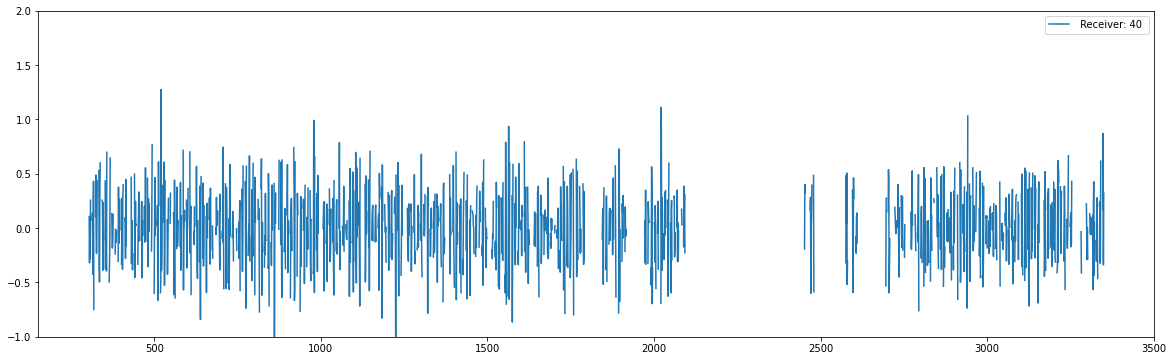

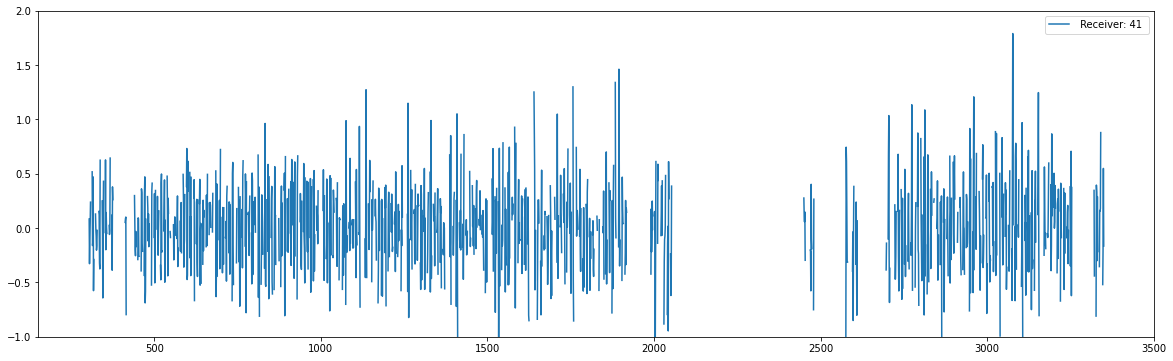

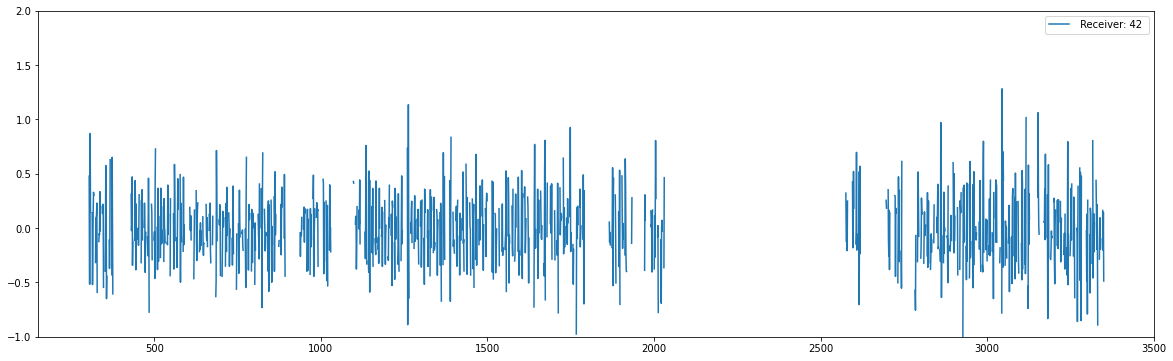

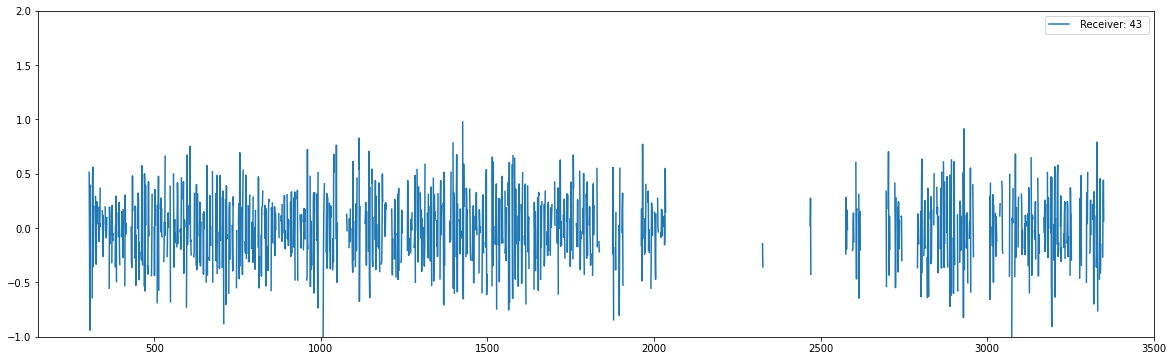

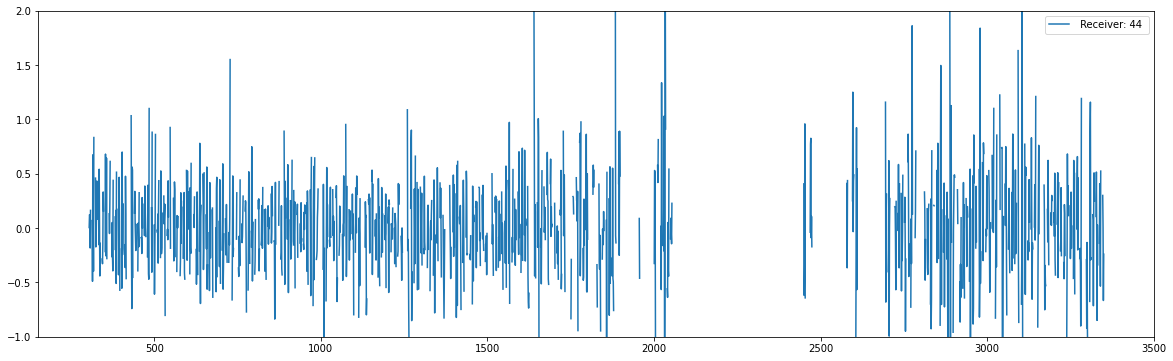

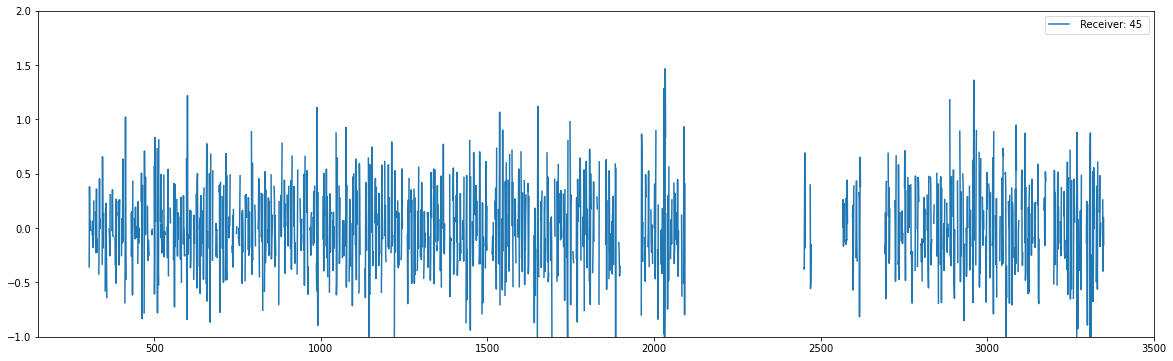

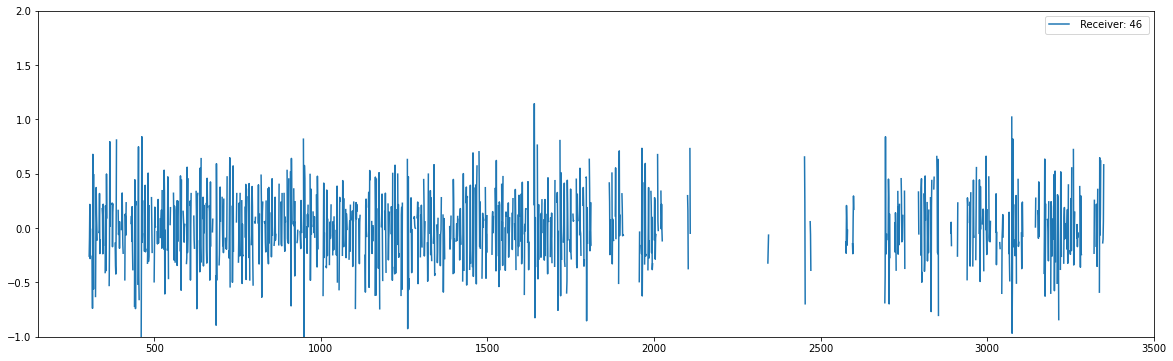

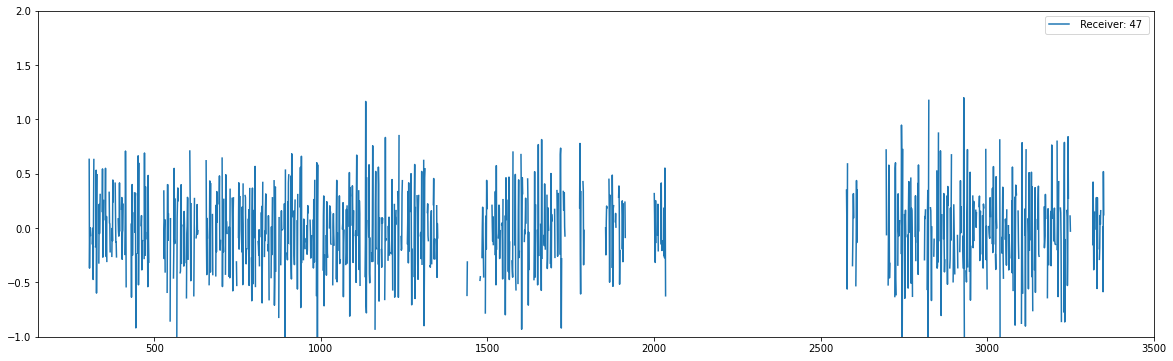

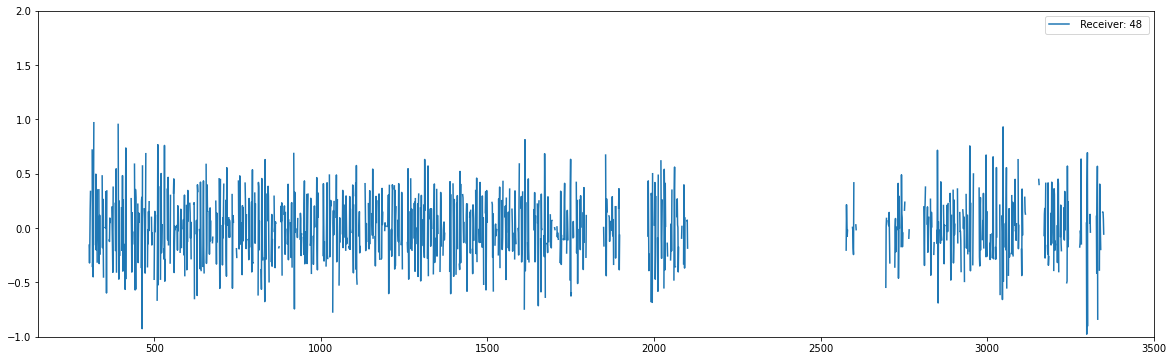

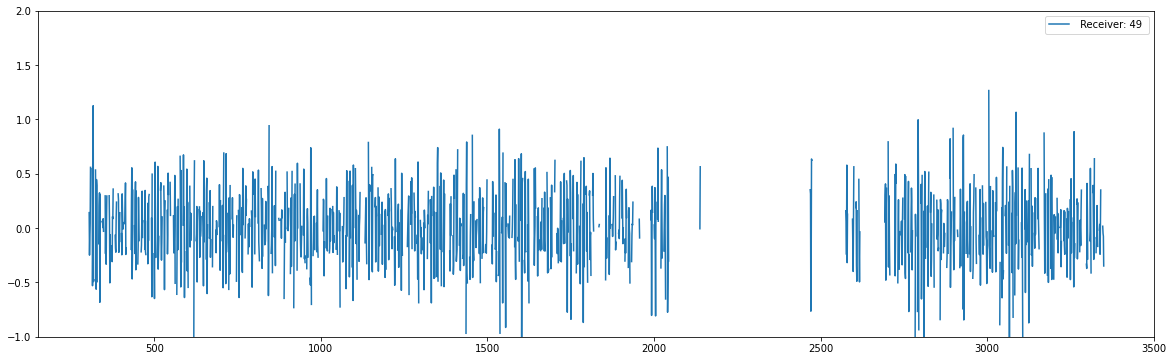

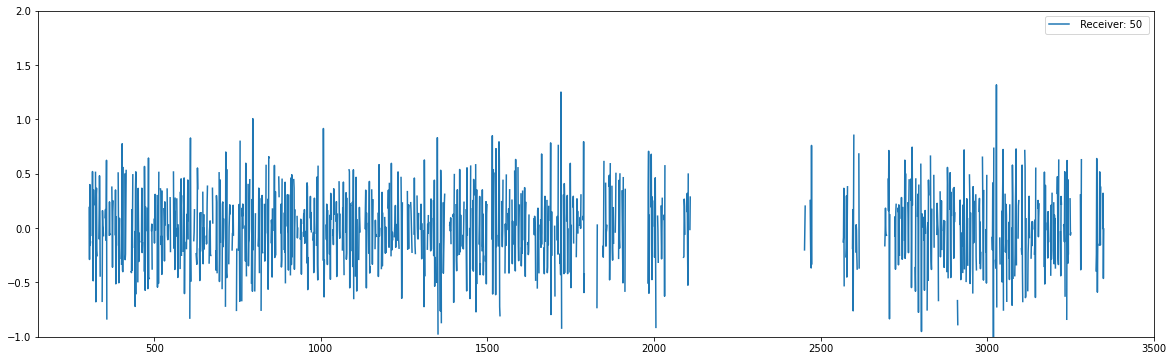

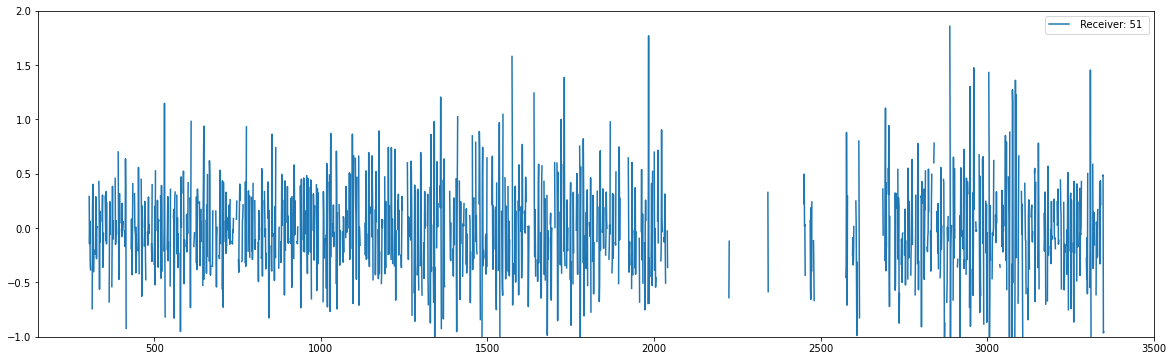

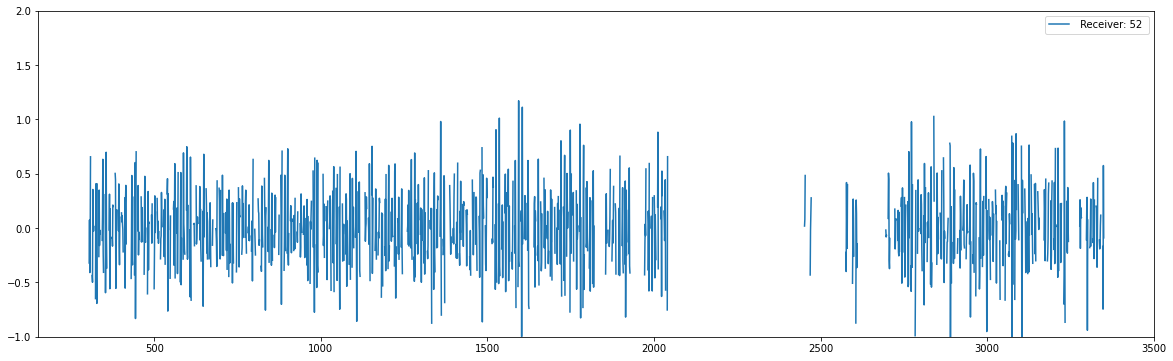

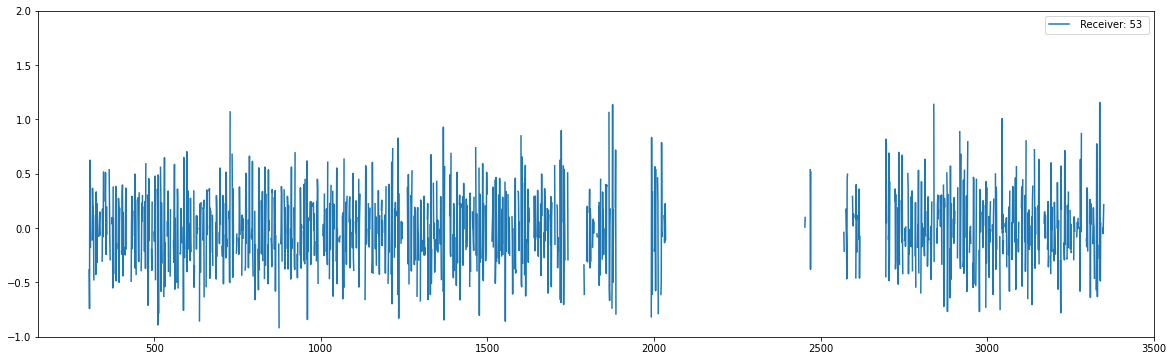

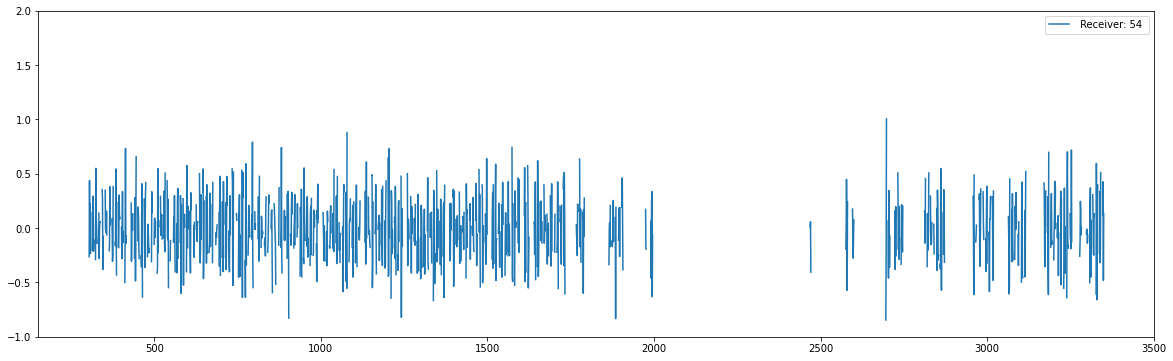

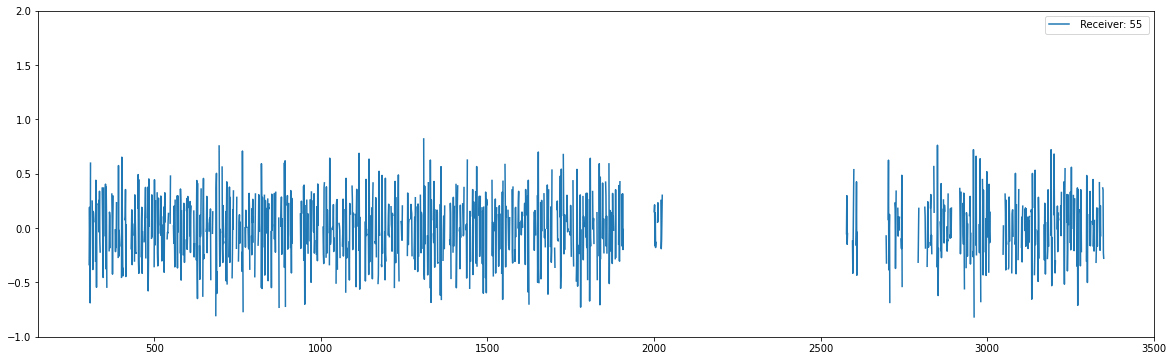

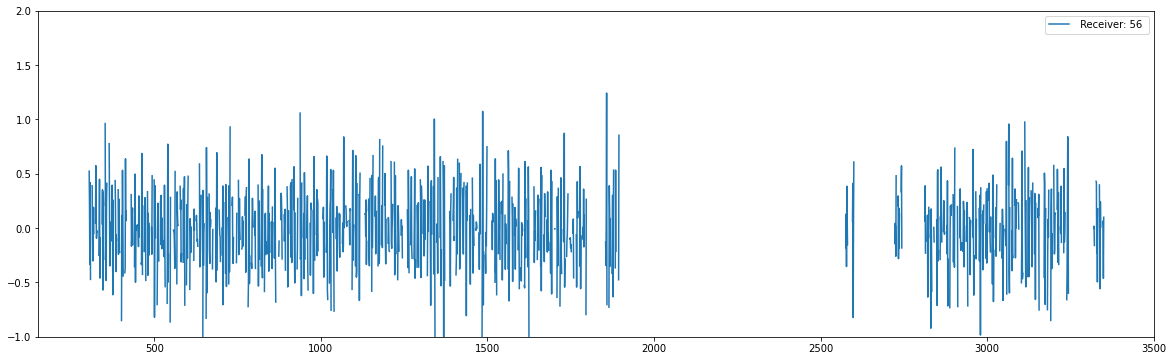

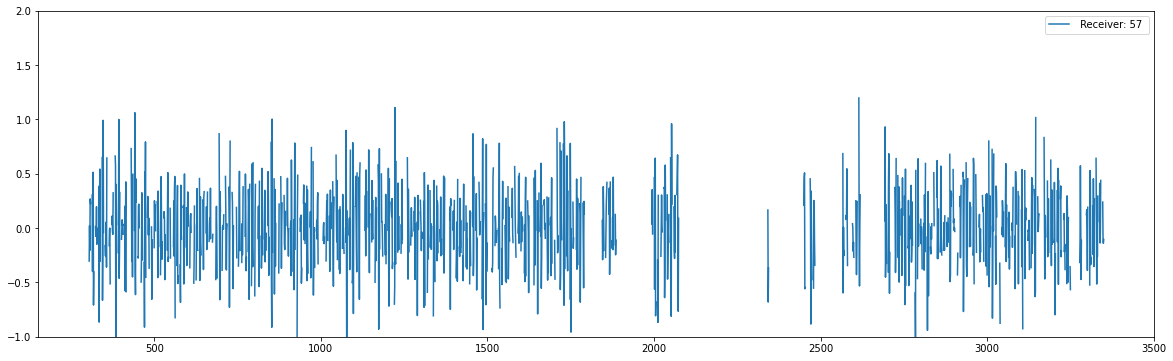

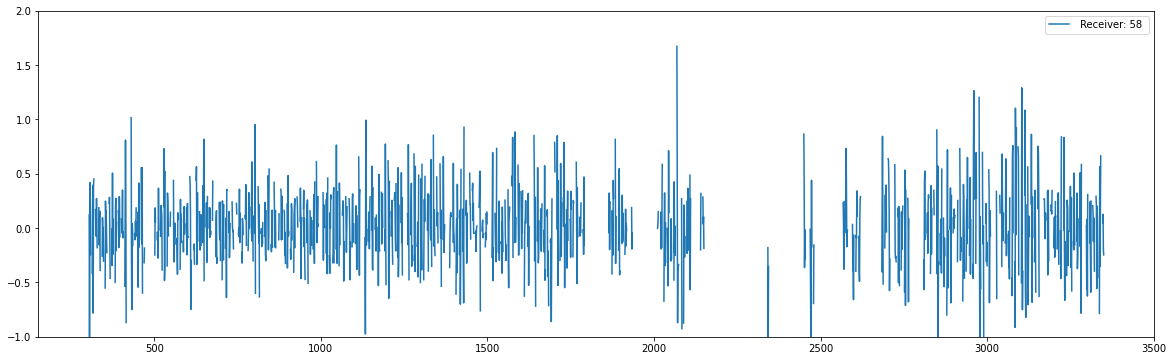

In [33]:
for i in range(0, len(ants)):
    plot(SS_all_ants[i, :, 3000], ylim= (-1,2), label = f" Receiver: {i} ")
   

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


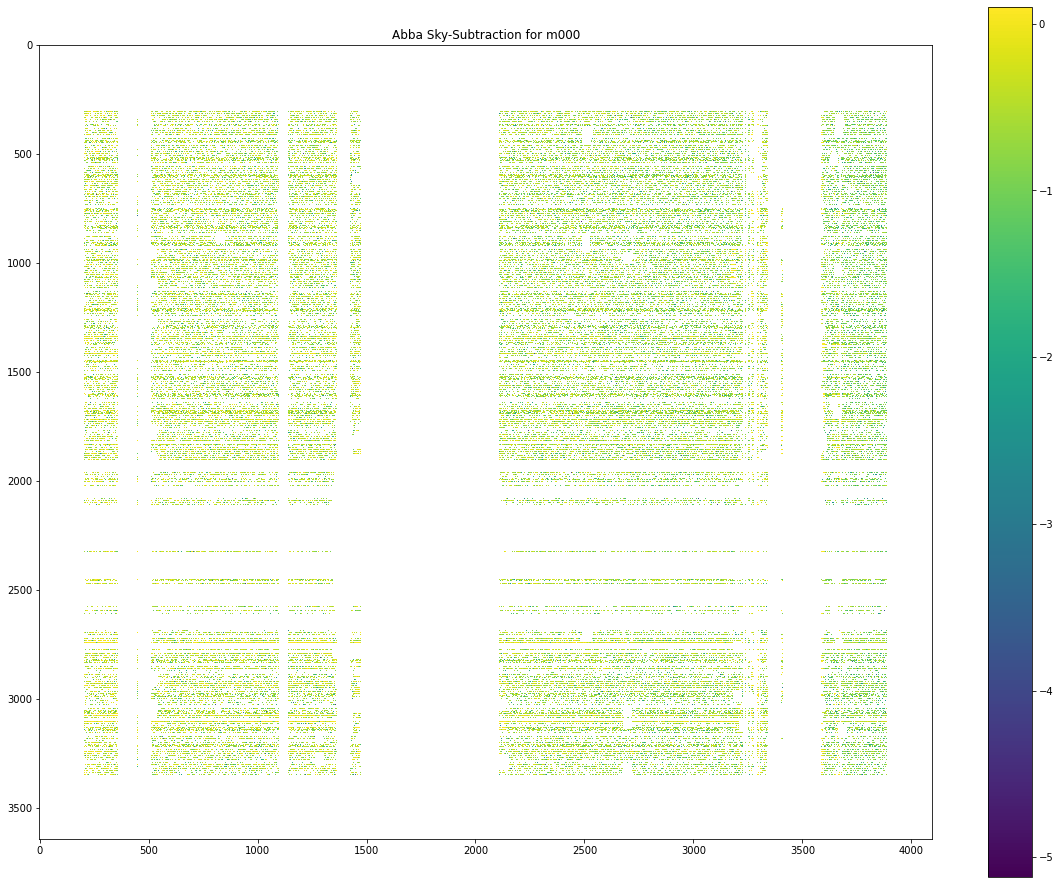

In [32]:
# need to ask Boom about the color bar for my function

plt.figure(figsize=(20,16))
plt.title('Abba Sky-Subtraction for m000')
plt.imshow(np.log10(SS_all_ants[0, :,:]), vmax=0.1, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


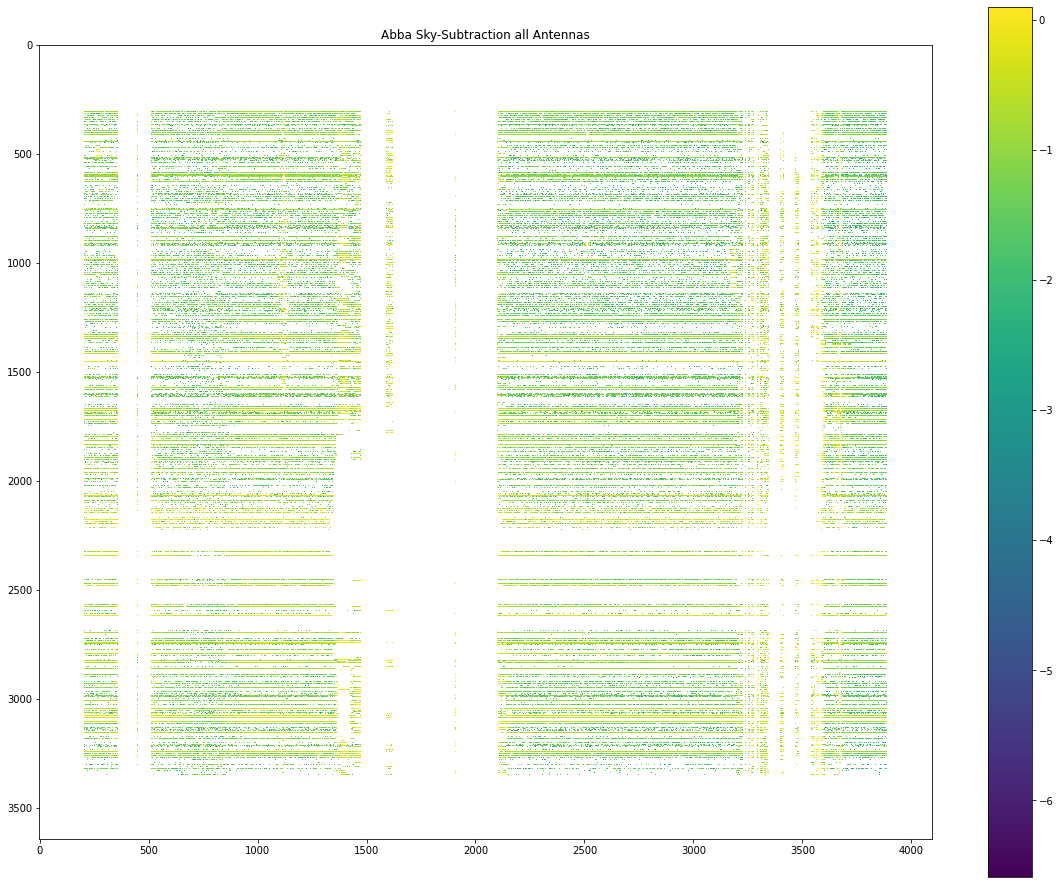

In [29]:

plt.figure(figsize=(20,16))
plt.title('Abba Sky-Subtraction all Antennas')
plt.imshow(np.log10(np.nanmean(SS_all_ants[:, :,:], axis=0)), vmax=0.1, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

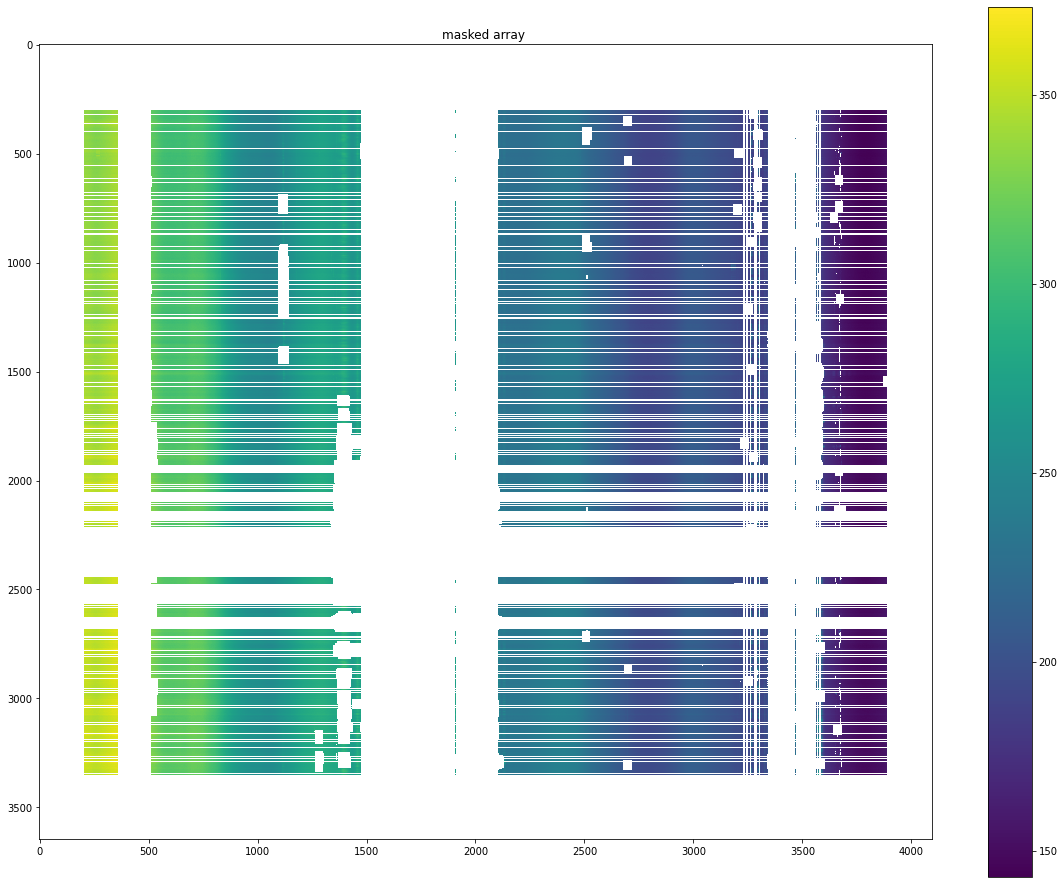

In [31]:

plt.figure(figsize=(20,16))
plt.title('masked array ')
plt.imshow(masked_data['m001'], cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [53]:
SS_all_ants[0, 1010:1200,3001]

array([-7.34329224e-02, -4.56741333e-01,             nan,             nan,
                   nan,             nan, -2.82752991e-01,  3.66394043e-01,
       -2.63519287e-01, -1.00204468e-01,  1.45912170e-01,  2.37884521e-02,
                   nan,             nan,             nan,             nan,
       -2.31361389e-01, -4.39628601e-01, -8.91189575e-02,  1.44828796e-01,
        3.45893860e-01, -3.69125366e-01,             nan,             nan,
                   nan,             nan,  3.32901001e-01, -2.39120483e-01,
       -1.94526672e-01,  2.98370361e-01,  4.41566467e-01,             nan,
                   nan,             nan,             nan,             nan,
       -1.76414490e-01,  3.56483459e-01,  1.31149292e-01, -5.47424316e-01,
       -3.55079651e-01,             nan,             nan,             nan,
                   nan, -1.43157959e-01,  1.32606506e-01, -1.04522705e-03,
       -1.20658875e-01,             nan,             nan,             nan,
                   nan,  

In [66]:
ss1ant = SS_all_ants[0,:,:]
ss1ant1freq = ss1ant[:,3001]


In [67]:
ss1ant1freq[~np.isnan(ss1ant1freq)].shape

(1237,)

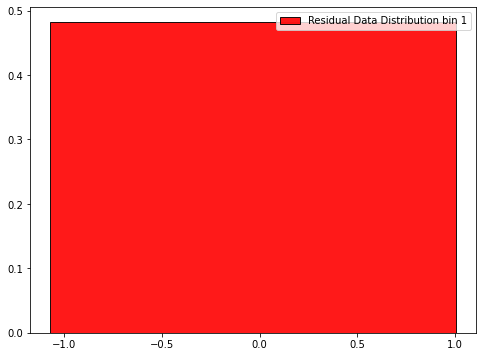

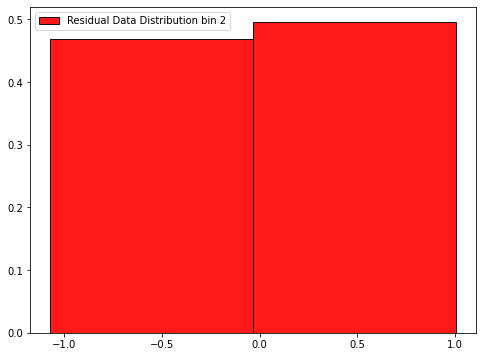

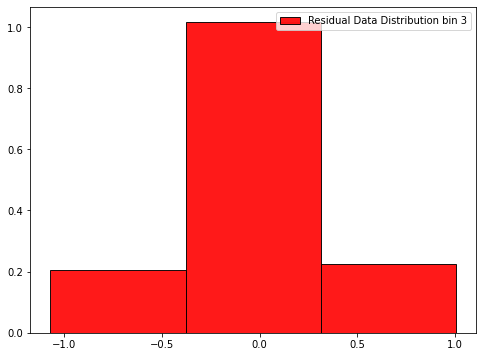

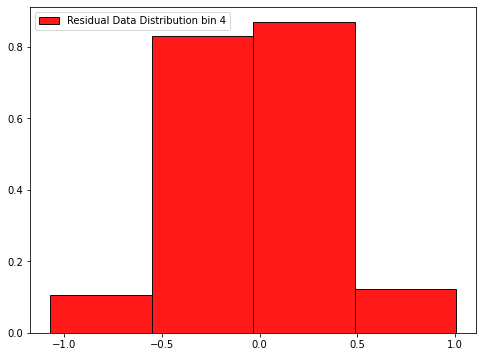

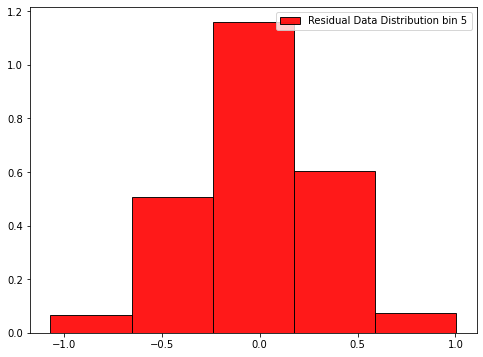

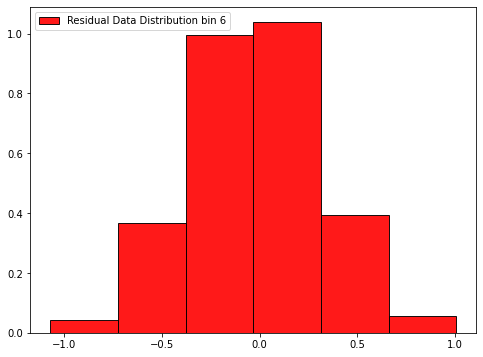

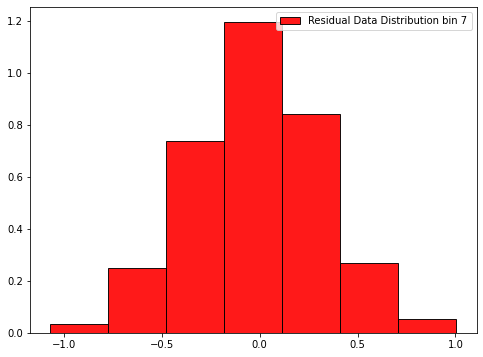

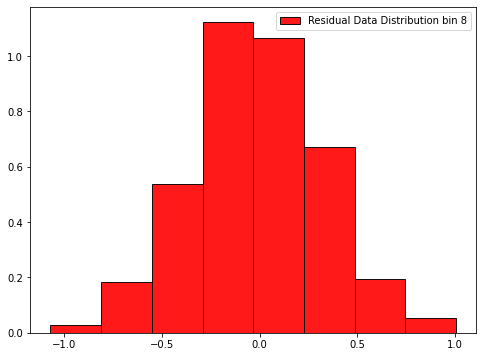

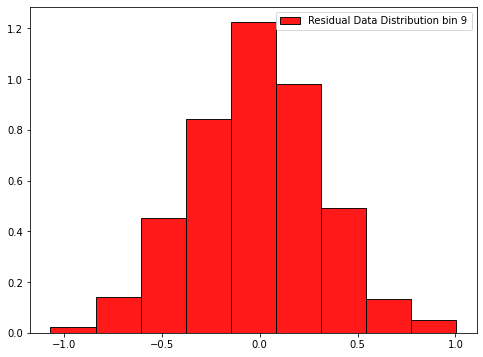

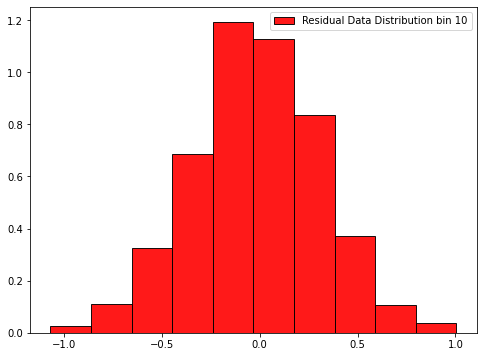

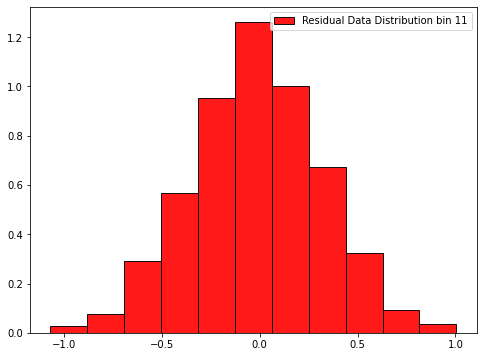

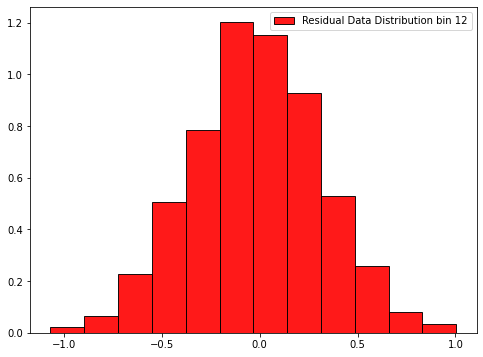

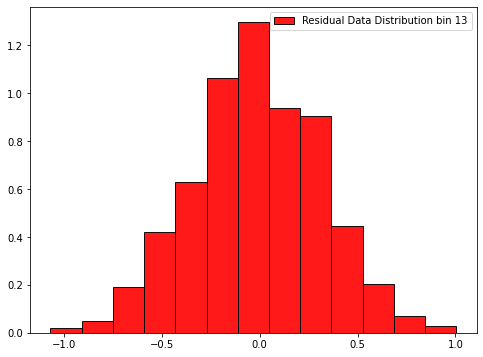

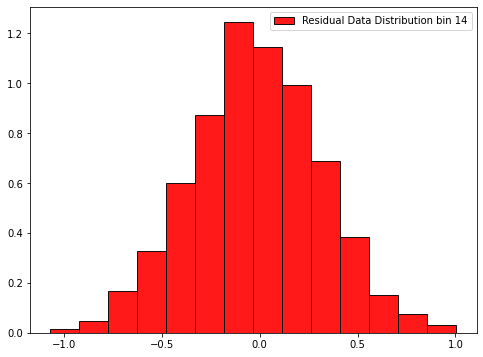

In [68]:
#Residual Data Plot

for i in range(1, 15):
    #print(i)
    plot_hist(ss1ant1freq[~np.isnan(ss1ant1freq)],bins=i, alpha=0.9, density=True, color='r', label= f'Residual Data Distribution bin {i}', figsize=(8,6))



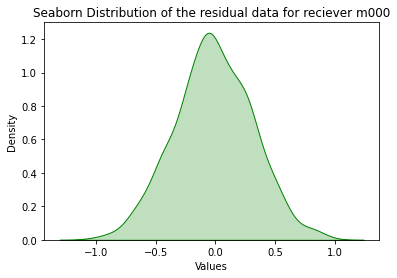

In [69]:
import seaborn as sns

sns.kdeplot(ss1ant1freq[~np.isnan(ss1ant1freq)], fill=True, color='green')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Seaborn Distribution of the residual data for reciever m000')
plt.show()
#Distibutions at receiver level look gaussian, i expect that more rigourous stats from the algorithmn to show more contrast

In [131]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |################################| 292 kB 11.0 MB/s            
     |################################| 9.5 MB 94 kB/s               
     |################################| 11.5 MB 44.5 MB/s            
     |################################| 1.1 MB 82.1 MB/s            
     |################################| 3.1 MB 33.8 MB/s            
     |################################| 229 kB 36.2 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astrokat 0.1.dev357+head.ef75b43 requires matplotlib<3, but you have matplotlib 3.3.4 which is incompatible.


In [70]:
averagedIn = np.nanmean(SS_all_ants[:,:,:],axis=0)
averagedIn1freq = averagedIn[:,3001]

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


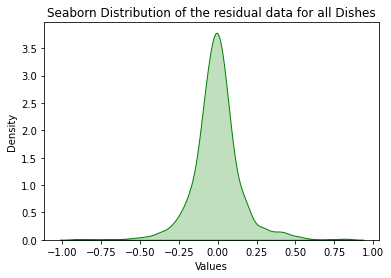

In [71]:
import seaborn as sns

sns.kdeplot(averagedIn1freq[~np.isnan(averagedIn1freq)] , fill=True, color='green')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Seaborn Distribution of the residual data for all Dishes')
plt.show()
